# Evaluate the question matcher using the existing harmonisation tool as a gold standard



In [1]:
import sys

sys.path.append("../front_end")


import bz2
import os
import pickle as pkl
import re
import sys
from nltk.corpus import stopwords
from langdetect import detect
import numpy as np

import pandas as pd

from utils.pt_en_dict import pt_en_map
from utils.spacy_wrapper import get_spacy_model


In [2]:
INPUT_FILE = "../data/Final harmonised item tool EM.xlsx"


In [3]:
initial_number_regex = re.compile(r'^\d+\.')

In [4]:
question_to_category_for_gold_standard = {}

# TODO: do Adulthood separately
question_dfs = []
for sheet_name in ("Childhood",):
    df = pd.read_excel(INPUT_FILE, sheet_name=sheet_name)

    if sheet_name == "Adulthood":
        labels_in_this_sheet = ["Adulthood"] * len(df)
        df = df[df.columns[4:]]
    else:
        labels_in_this_sheet = list(df["Developmental period"])
        df = df[df.columns[5:]]
        

    for idx in range(0, len(df)):
        if idx > 10:
            break
        questions = {}
        
        q_to_c = {}
        ctr = 0
        
        for j in range(len(df.columns)):
            col_name = df.columns[j]
            text = df[col_name].iloc[idx]
            if type(text) is str and len(text) > 1:
                for q in text.split("/"):
                    q = q.strip()
                    
                    m = initial_number_regex.match(q)
                    if m:
                        number = int(re.sub(r'\.', '', m.group()))
                        questions[number] = initial_number_regex.sub("", q).strip()
                        q_to_c[number] = col_name.strip()
                    elif len(q) > 1:
                        number = ctr
                        questions[number] = q
                        q_to_c[number] = col_name.strip()
                        ctr += 1
        
        if len(questions) > 0:
            question_df = pd.DataFrame({"number":sorted(questions)})
            for j in range(len(question_df)):
                q_no = question_df.number.iloc[j]
                question_to_category_for_gold_standard[(len(question_dfs), j)] = q_to_c[q_no]


            question_df.attrs["language"] = "en"
            question_df["question"] = question_df.number.apply(lambda n : questions[n])
        
#             question_df["question"] = question_df["question"].apply(
#                 lambda x : re.sub(r'(?i)\b(i|me|myself|you|yourself|am|are|mine|my|your|yours)\b', '', x)
#             )
        
        
            question_dfs.append(question_df)

In [5]:
category_to_question_groups_for_gold_standard = {}
for key, value in question_to_category_for_gold_standard.items():
    category_to_question_groups_for_gold_standard.setdefault(value, [])
    category_to_question_groups_for_gold_standard[value].append(key)

In [6]:
gold_standard = []
for key, groups in category_to_question_groups_for_gold_standard.items():
    if len(groups) > 1:
        for i in range(len(groups)):
            for j in range(i + 1, len(groups)):
                gold_standard.append((groups[i][0], groups[i][1], groups[j][0], groups[j][1]))

In [7]:
gold_standard_dict = {}
for i in range(len(question_dfs)):
    for idx in range(len(question_dfs[i])):
        for j in range(i + 1, len(question_dfs)):
            for jdx in range(len(question_dfs[j])):
                gold_standard_dict[(i, idx, j, jdx)] = 0
for g in gold_standard:
    gold_standard_dict[g] = 1

In [8]:
len(gold_standard_dict)

30007

In [9]:
len(question_dfs)

11

In [10]:
from utils.question_matcher_transformer_huggingface_negation import QuestionMatcherTransformerHuggingFaceNegation

In [11]:
qm = QuestionMatcherTransformerHuggingFaceNegation()

In [14]:
matches = qm.match_questions(question_dfs)

In [15]:
matches_pruned = [m for m in matches if abs(matches[m]) > 0.5]

print ("Number of matches found", len(set(matches_pruned)))
print ("Number of matches in gold standard", len(set(gold_standard)))
print ("Number of matches found which were in gold standard",len(set(matches_pruned).intersection(set(gold_standard))))
print ("Number of matches found which were not in standard",len(set(matches_pruned).difference(set(gold_standard))))

print ("Jaccard", len(set(matches_pruned).intersection(set(gold_standard))) / len(set(matches_pruned).union(set(gold_standard))))

Number of matches found 1209
Number of matches in gold standard 2102
Number of matches found which were in gold standard 599
Number of matches found which were not in standard 610
Jaccard 0.2208702064896755


In [16]:
for m in matches_pruned:
    if m in gold_standard:
        print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]])

Cries Easily = She cries easily
Cries Easily = She gest upset easily
Fights With Other Children = Often fights with other children or bullies them
Bullies Other Children = Often fights with other children or bullies them
Bites or Kicks Other Children = Often fights with other children or bullies them
Worries about Many Things = Has many worries, often seems worried
Will Help Someone who is Hurt = Is helpful if someone is hurt, upset or feeling ill
Is Kind to Young Children = Is kind to younger children
Is Considerate for Others = Is considerate of other people's feelings
Is Afraid of New Things = Has many fears, is easily scared
Is Restless and Doesnt keep still = Is restless, overactive, cannot stay still for long
Other Children Dislike Child = Is generally liked by other children
Other Children Dislike Child = Is picked on or bullied by other children
Gets on With Other Children = Is generally liked by other children
Gets on With Other Children = Is picked on or bullied by other chil

She is very friendly with strangers = She is very sociable
She is very friendly with strangers = She is very friendly with strangers
She prefers playing with other rather than alone = her own rather than with others
When alone she feels isolated = her own rather than with others
She prefers playing with other rather than alone = Is rather solitary, tends to play alone
She makes friends easily = Has at least one good friends
When alone she feels isolated = Is rather solitary, tends to play alone
She is very friendly with strangers = Has at least one good friends
Is restless, overactive, cannot stay still for long = Child is very restless, hardly ever still
Is rather solitary, tends to play alone = Child is rather solitary
Has many worries, often seems worried = Child worries about many things
Is constantly fidgeting or squirming = Child is squirmy or fidgety
Often fights with other children or bullies them = Child fights with other children
Often fights with other children or bullies th

In [17]:
for m in matches_pruned:
    if m not in gold_standard:
        print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]])

Shares Treats With Friends = She makes friends easily
Gives Up Easily = She gest upset easily
Has Speech Difficulty = She gest upset easily
Fights With Other Children = Shares readily with other children (treats, toys, pencils etc)
Fights With Other Children = Is generally liked by other children
Fights With Other Children = Is picked on or bullied by other children
Fights With Other Children = Gets on better with adults than with other children
Bullies Other Children = Is generally liked by other children
Bullies Other Children = Is picked on or bullied by other children
Bites or Kicks Other Children = Is picked on or bullied by other children
Is Inconsiderate of Others = Is considerate of other people's feelings
Worries about Many Things = Has many fears, is easily scared
Shares Treats With Friends = Has at least one good friends
Other Children Dislike Child = Gets on better with adults than with other children
Gets on With Other Children = Shares readily with other children (treats,

Child worries about many things = Child is not much liked by other children
Child tells lies = Child is disobedient
Child takes things belonging to others = Child fights with other children
Child takes things belonging to others = Child bullies other children
Child takes things belonging to others = Child is disobedient
Child takes things belonging to others = Child destroys her own things or those belonging to others
Child takes things belonging to others = Child worries about many things
Child takes things belonging to others = Child cannot settle to do anything for more than a few moments
Child takes things belonging to others = Child is not much liked by other children
Child likes a cuddle = Child laughs a lot
Child likes a cuddle = Child really enjoys life
Child likes a cuddle = Child is not much liked by other children
Child smiles when child sees their parent(s) = Child laughs a lot
Child is afraid of new things or new situations = Child worries about many things
Child bites the

In [18]:
for m in gold_standard:
    if m not in matches:
        print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]])

Child appears miserable, unhappy, tearful or distressed = Child laughs a lot
Child appears miserable, unhappy, tearful or distressed = Child really enjoys life
Child laughs a lot = Child really enjoys life
Child appears miserable, unhappy, tearful or distressed = Child laughs a lot
Child appears miserable, unhappy, tearful or distressed = Child really enjoys life
Child laughs a lot = Child really enjoys life
Fights With Other Children = Bullies Other Children
Fights With Other Children = Bites or Kicks Other Children
Bullies Other Children = Bites or Kicks Other Children
Frequently fights other children = Bullies other children
Child fights with other children = Child bullies other children
Child fights with other children = Child bullies other children
Is Disobedient = Is Inconsiderate of Others
Is generally obedient, usually does what adults request = Often argumentative with adults
Tells Lies = Blames Other for Things
Tries to be Fair in Games = Is Affectionate to Family Members
Tri

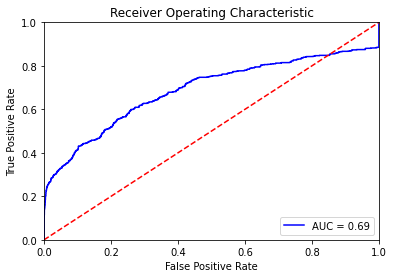

In [19]:
import sklearn.metrics as metrics

y_pred = []
y_test = []
for m, g in gold_standard_dict.items():
    y_pred.append(abs(matches.get(m, 0)))
    y_test.append(g)
    
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [20]:
print ("FALSE NEGATIVES")

import operator 
all_positives = [m for m in gold_standard_dict if gold_standard_dict[m] == 1 ]
estimated_values_for_gt_1 = dict([(m,abs(matches.get(m, 0))) for m in all_positives])

for m, v in sorted(estimated_values_for_gt_1.items(), key=operator.itemgetter(1)):
    print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]], v)

FALSE NEGATIVES
Child appears miserable, unhappy, tearful or distressed = Child laughs a lot 0
Child appears miserable, unhappy, tearful or distressed = Child really enjoys life 0
Child laughs a lot = Child really enjoys life 0
Child appears miserable, unhappy, tearful or distressed = Child laughs a lot 0
Child appears miserable, unhappy, tearful or distressed = Child really enjoys life 0
Child laughs a lot = Child really enjoys life 0
Fights With Other Children = Bullies Other Children 0
Fights With Other Children = Bites or Kicks Other Children 0
Bullies Other Children = Bites or Kicks Other Children 0
Frequently fights other children = Bullies other children 0
Child fights with other children = Child bullies other children 0
Child fights with other children = Child bullies other children 0
Is Disobedient = Is Inconsiderate of Others 0
Is generally obedient, usually does what adults request = Often argumentative with adults 0
Tells Lies = Blames Other for Things 0
Tries to be Fair in

Is constantly fidgeting or squirming = Child cannot settle to do anything for more than a few moments 0.18525350838899612
Child cannot settle to do anything for more than a few moments = Is constantly fidgeting or squirming 0.18525350838899612
Child cannot settle to do anything for more than a few moments = Is constantly fidgeting or squirming 0.18525350838899612
Is constantly fidgeting or squirming = Child cannot settle to do anything for more than a few moments 0.18525350838899612
Child cannot settle to do anything for more than a few moments = Is constantly fidgeting or squirming 0.18525350838899612
Will Help Someone who is Hurt = Is kind to younger children 0.18656164407730103
Will Help Someone who is Hurt = Is kind to younger children 0.18656164407730103
Will Help Someone who is Hurt = Is kind to younger children 0.18656164407730103
When alone she feels isolated = Prefers to do things on his 0.18662822246551514
When alone she feels isolated = Prefers to do things on his 0.18662822

Has Short Attention Span = Sees tasks through to the end, has good attention span 0.2850981652736664
Has Short Attention Span = Sees tasks through to the end, has good attention span 0.2850981652736664
Has Short Attention Span = Sees tasks through to the end, has good attention span 0.2850981652736664
She is always on the go = Very restless. Often running about or jumping up and down. Hardly ever still 0.2858307510614395
Very restless. Often running about or jumping up and down. Hardly ever still = She is always on the go 0.2858307510614395
Very restless. Often running about or jumping up and down. Hardly ever still = She is always on the go 0.2858307510614395
Is Irritable = She reacts intensely when upset 0.28743088245391846
Is Irritable = She reacts intensely when upset 0.28743088245391846
Is Irritable = She reacts intensely when upset 0.28743088245391846
Is Kind to Young Children = Shares readily with other children (treats, toys, pencils etc) 0.2892281711101532
Is Kind to Young Chi

She cries easily = She tends to be somewhat emotional 0.557452917098999
She tends to be somewhat emotional = She cries easily 0.557452917098999
Not much liked by other children. = Is bullied by other children 0.5589242577552795
Is restless, overactive, cannot stay still for long = Child is very restless, hardly ever still 0.5596235692501068
Is restless, overactive, cannot stay still for long = Child is very restless, hardly ever still 0.5596235692501068
Child is very restless, hardly ever still = Is restless, overactive, cannot stay still for long 0.5596235692501068
Child is very restless, hardly ever still = Is restless, overactive, cannot stay still for long 0.5596235692501068
Is restless, overactive, cannot stay still for long = Child is very restless, hardly ever still 0.5596235692501068
Child is very restless, hardly ever still = Is restless, overactive, cannot stay still for long 0.5596235692501068
Is Restless and Doesnt keep still = Child is very restless, hardly ever still 0.56

She is always on the go = She is always on the go 1.0
She prefers playing with other rather than alone = She prefers playing with other rather than alone 1.0
She tends to be somewhat emotional = She tends to be somewhat emotional 1.0
When she moves about she tends to move slowly = When she moves about she tends to move slowly 1.0
She makes friends easily = She makes friends easily 1.0
She is off and running as soon as she wakes up in the morning = She is off and running as soon as she wakes up in the morning 1.0
She finds people more stimulating than anything else = She finds people more stimulating than anything else 1.0
She often fusses and cries = She often fusses and cries 1.0
She is very sociable = She is very sociable 1.0
She is very energentic = She is very energentic 1.0
She takes a long time to warm up to strangers = She takes a long time to warm up to strangers 1.0
She gest upset easily = She gest upset easily 1.0
She is something of a loner = She is something of a loner 1.0


In [21]:
print ("FALSE POSITIVES")

import operator 
all_negatives = [m for m in gold_standard_dict if gold_standard_dict[m] == 0 ]
estimated_values_for_gt_0 = dict([(m, abs(matches.get(m, 0))) for m in all_negatives])

for m, v in sorted(estimated_values_for_gt_0.items(), key=operator.itemgetter(1), reverse=True):
    print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]], v)

FALSE POSITIVES
Gets on With Other Children = Fights with other children 0.885499119758606
Other Children Dislike Child = Child bullies other children 0.8017560839653015
Other Children Dislike Child = Child bullies other children 0.8017560839653015
Child bullies other children = Is bullied by other children 0.7982100248336792
Child bullies other children = Is bullied by other children 0.7982100248336792
Other Children Dislike Child = Bullies other children 0.7879873514175415
Bullies other children = Is bullied by other children 0.7878776788711548
Gets on With Other Children = Child fights with other children 0.7872905731201172
Gets on With Other Children = Child fights with other children 0.7872905731201172
Bullies Other Children = Is bullied by other children 0.7559332847595215
Other Children Dislike Child = Fights with other children 0.7435921430587769
Gets on With Other Children = Child bullies other children 0.743426501750946
Gets on With Other Children = Child bullies other childr

Child takes things belonging to others = Child worries about many things 0.5429544448852539
Fights With Other Children = Is generally liked by other children 0.5428896546363831
Fights With Other Children = Is generally liked by other children 0.5428896546363831
Fights With Other Children = Is generally liked by other children 0.5428896546363831
Child takes things belonging to others = Child cannot settle to do anything for more than a few moments 0.5417485237121582
Child cannot settle to do anything for more than a few moments = Child takes things belonging to others 0.5417485237121582
She tends to be shy = She cries easily 0.5380682349205017
She tends to be shy = She cries easily 0.5380682349205017
She cries easily = She tends to be shy 0.5380682349205017
She cries easily = She tends to be shy 0.5380682349205017
She tends to be shy = She cries easily 0.5380682349205017
She cries easily = She tends to be shy 0.5380682349205017
Is generally liked by other children = Gets on better with 

Frequently fights other children = Gets on better with adults than with other children 0.5174623727798462
Sometimes takes things belonging to others = her own rather than with others 0.5173966884613037
Is considerate of other people's feelings = Sometimes takes things belonging to others 0.5160043239593506
Sometimes takes things belonging to others = Is considerate of other people's feelings 0.5160043239593506
Sometimes takes things belonging to others = Is considerate of other people's feelings 0.5160043239593506
Child cannot settle to do anything for more than a few moments = Child is not much liked by other children 0.5159342885017395
Child is not much liked by other children = Child cannot settle to do anything for more than a few moments 0.5159342885017395
Is generally liked by other children = Child likes a cuddle 0.515268087387085
Is generally liked by other children = Child likes a cuddle 0.515268087387085
Child likes a cuddle = Is generally liked by other children 0.5152680873

Child is disobedient = Is kind to younger children 0.4916055500507355
Is kind to younger children = Child is disobedient 0.4916055500507355
Child is disobedient = Is kind to younger children 0.4916055500507355
Child bullies other children = Child tells lies 0.49153202772140503
Child tells lies = Child bullies other children 0.49153202772140503
Frequently sucks thumb or finger = Often lies or cheats 0.49149593710899353
Frequently sucks thumb or finger = Often lies or cheats 0.49149593710899353
Is generally liked by other children = Child really enjoys life 0.49121809005737305
Is generally liked by other children = Child really enjoys life 0.49121809005737305
Child really enjoys life = Is generally liked by other children 0.49121809005737305
Child really enjoys life = Is generally liked by other children 0.49121809005737305
Is generally liked by other children = Child really enjoys life 0.49121809005737305
Child really enjoys life = Is generally liked by other children 0.4912180900573730

She is very sociable = She is always on the go 0.47288766503334045
She is very sociable = She is always on the go 0.47288766503334045
She is always on the go = She is very sociable 0.47288766503334045
She is very sociable = She is always on the go 0.47288766503334045
Is kind to younger children = Child is rather solitary 0.4726378321647644
Is kind to younger children = Child is rather solitary 0.4726378321647644
Child is rather solitary = Is kind to younger children 0.4726378321647644
Child is rather solitary = Is kind to younger children 0.4726378321647644
Is kind to younger children = Child is rather solitary 0.4726378321647644
Child is rather solitary = Is kind to younger children 0.4726378321647644
Child smiles when child sees their parent(s) = Child is not much liked by other children 0.472110390663147
Child is not much liked by other children = Child smiles when child sees their parent(s) 0.472110390663147
Child is disobedient = Child is very restless, hardly ever still 0.4714355

She is very friendly with strangers = her own rather than with others 0.45847031474113464
Is Kind to Young Children = Child tells lies 0.45843207836151123
Is Kind to Young Children = Child tells lies 0.45843207836151123
She tends to be somewhat emotional = When alone she feels isolated 0.4579601585865021
She tends to be somewhat emotional = When alone she feels isolated 0.4579601585865021
When alone she feels isolated = She tends to be somewhat emotional 0.4579601585865021
When alone she feels isolated = She tends to be somewhat emotional 0.4579601585865021
She tends to be somewhat emotional = When alone she feels isolated 0.4579601585865021
When alone she feels isolated = She tends to be somewhat emotional 0.4579601585865021
Child fights with other children = Child destroys her own things or those belonging to others 0.457524836063385
Child destroys her own things or those belonging to others = Child fights with other children 0.457524836063385
Does things on Own = Prefers to do thing

Is often unhappy, down hearted or tearful = Has many worries, often seems worried 0.4454037547111511
Has many worries, often seems worried = Is often unhappy, down hearted or tearful 0.4454037547111511
Is often unhappy, down hearted or tearful = Has many worries, often seems worried 0.4454037547111511
Frequently fights other children = Child is disobedient 0.44525665044784546
Frequently fights other children = Child is disobedient 0.44525665044784546
Other Children Dislike Child = Child is afraid of new things or new situations 0.44518595933914185
Other Children Dislike Child = Child is afraid of new things or new situations 0.44518595933914185
Is kind to younger children = Child really enjoys life 0.4448684751987457
Is kind to younger children = Child really enjoys life 0.4448684751987457
Child really enjoys life = Is kind to younger children 0.4448684751987457
Child really enjoys life = Is kind to younger children 0.4448684751987457
Is kind to younger children = Child really enjoys l

Child is disobedient = Is picked on or bullied by other children 0.42740339040756226
Is picked on or bullied by other children = Child is disobedient 0.42740339040756226
Child is disobedient = Is picked on or bullied by other children 0.42740339040756226
Child laughs a lot = Child bullies other children 0.4269595742225647
Child bullies other children = Child laughs a lot 0.4269595742225647
Is kind to younger children = Is picked on or bullied by other children 0.4266318380832672
Is kind to younger children = Is picked on or bullied by other children 0.4266318380832672
Is picked on or bullied by other children = Is kind to younger children 0.4266318380832672
Is picked on or bullied by other children = Is kind to younger children 0.4266318380832672
Is kind to younger children = Is picked on or bullied by other children 0.4266318380832672
Is picked on or bullied by other children = Is kind to younger children 0.4266318380832672
Bites or Kicks Other Children = Is kind to younger children 0

Gets on With Other Children = Child destroys her own things or those belonging to others 0.4132145047187805
Is Inattentive = Is often disobedient 0.41304194927215576
Bullies Other Children = Shares readily with other children (treats, toys, pencils etc) 0.412349671125412
Bullies Other Children = Shares readily with other children (treats, toys, pencils etc) 0.412349671125412
Bullies Other Children = Shares readily with other children (treats, toys, pencils etc) 0.412349671125412
She often fusses and cries = Often tells lies 0.41229942440986633
Often tells lies = She often fusses and cries 0.41229942440986633
Often tells lies = She often fusses and cries 0.41229942440986633
Shares readily with other children (treats, toys, pencils etc) = Is bullied by other children 0.41220027208328247
Shares readily with other children (treats, toys, pencils etc) = Is bullied by other children 0.41220027208328247
Is bullied by other children = Shares readily with other children (treats, toys, pencils e

She is very friendly with strangers = She reacts intensely when upset 0.39387941360473633
She is very friendly with strangers = She reacts intensely when upset 0.39387941360473633
She reacts intensely when upset = She is very friendly with strangers 0.39387941360473633
She is very friendly with strangers = She reacts intensely when upset 0.39387941360473633
Is generally liked by other children = Child cannot settle to do anything for more than a few moments 0.39381249248981476
Is generally liked by other children = Child cannot settle to do anything for more than a few moments 0.39381249248981476
Child cannot settle to do anything for more than a few moments = Is generally liked by other children 0.39381249248981476
Child cannot settle to do anything for more than a few moments = Is generally liked by other children 0.39381249248981476
Is generally liked by other children = Child cannot settle to do anything for more than a few moments 0.39381249248981476
Child cannot settle to do anyt

Child is squirmy or fidgety = Is bullied by other children 0.38444529473781586
Child tells lies = Child smiles when child sees their parent(s) 0.384347140789032
Child smiles when child sees their parent(s) = Child tells lies 0.384347140789032
Comforts Child who Is Upset = Child is irritable. Is quick to fly off the handle 0.3842986971139908
Comforts Child who Is Upset = Child is irritable. Is quick to fly off the handle 0.3842986971139908
Child really enjoys life = Child is fussy or over-particular 0.3842911422252655
Child is fussy or over-particular = Child really enjoys life 0.3842911422252655
Bullies other children = Child is rather solitary 0.3839435577392578
Bullies other children = Child is rather solitary 0.3839435577392578
Appears Miserable or Tearful = Child is fussy or over-particular 0.38382846117019653
Appears Miserable or Tearful = Child is fussy or over-particular 0.38382846117019653
Frequently fights other children = Child is afraid of new things or new situations 0.3837

Child worries about many things = Child likes a cuddle 0.37470757961273193
Child likes a cuddle = Child worries about many things 0.37470757961273193
She cries easily = Is often unhappy, down hearted or tearful 0.3744259774684906
She cries easily = Is often unhappy, down hearted or tearful 0.3744259774684906
She cries easily = Is often unhappy, down hearted or tearful 0.3744259774684906
Is often unhappy, down hearted or tearful = She cries easily 0.3744259774684906
Is often unhappy, down hearted or tearful = She cries easily 0.3744259774684906
She cries easily = Is often unhappy, down hearted or tearful 0.3744259774684906
She cries easily = Is often unhappy, down hearted or tearful 0.3744259774684906
Is often unhappy, down hearted or tearful = She cries easily 0.3744259774684906
She cries easily = Is often unhappy, down hearted or tearful 0.3744259774684906
Worries about Many Things = Has difficulty in settling to anything for more than a few moments 0.37423914670944214
Child likes a c

Cries Easily = Is often unhappy, down hearted or tearful 0.3654385954141617
Cries Easily = Is often unhappy, down hearted or tearful 0.3654385954141617
Is Considerate for Others = Child bullies other children 0.3652583658695221
Is Considerate for Others = Child bullies other children 0.3652583658695221
Child is afraid of new things or new situations = Child is very restless, hardly ever still 0.3651968240737915
Child is very restless, hardly ever still = Child is afraid of new things or new situations 0.3651968240737915
Bullies Other Children = Child cannot settle to do anything for more than a few moments 0.3651668429374695
Bullies Other Children = Child cannot settle to do anything for more than a few moments 0.3651668429374695
Often lies or cheats = Is miserable or tearful 0.3648340702056885
Is miserable or tearful = Often lies or cheats 0.3648340702056885
Is Irritable = Is squirmy or fidgety 0.36460910737514496
Is Irritable = Is squirmy or fidgety 0.36460910737514496
Child fights w

She cries easily = Often appears miserable, unhappy, tearful or distressed 0.35273022949695587
Often appears miserable, unhappy, tearful or distressed = She cries easily 0.35273022949695587
Often appears miserable, unhappy, tearful or distressed = She cries easily 0.35273022949695587
Is picked on or bullied by other children = Is miserable or tearful 0.35271692276000977
Is picked on or bullied by other children = Is miserable or tearful 0.35271692276000977
Is miserable or tearful = Is picked on or bullied by other children 0.35271692276000977
Doesnt Share Toys = Sometimes takes things belonging to others 0.3527110069990158
Cries Easily = Has many fears, is easily scared 0.3524937629699707
Cries Easily = Has many fears, is easily scared 0.3524937629699707
Cries Easily = Has many fears, is easily scared 0.3524937629699707
Often appears miserable, unhappy, tearful or distressed = Destroys own or others' belongings (e.g. tears or breaks) 0.3524823784828186
Is Restless and Doesnt keep still

Often tells lies = She tends to be shy 0.34618955850601196
Is constantly fidgeting or squirming = Is picked on or bullied by other children 0.3460995554924011
Is constantly fidgeting or squirming = Is picked on or bullied by other children 0.3460995554924011
Is picked on or bullied by other children = Is constantly fidgeting or squirming 0.3460995554924011
Is picked on or bullied by other children = Is constantly fidgeting or squirming 0.3460995554924011
Is constantly fidgeting or squirming = Is picked on or bullied by other children 0.3460995554924011
Is picked on or bullied by other children = Is constantly fidgeting or squirming 0.3460995554924011
She makes friends easily = She often fusses and cries 0.3459984064102173
She makes friends easily = She often fusses and cries 0.3459984064102173
She often fusses and cries = She makes friends easily 0.3459984064102173
She often fusses and cries = She makes friends easily 0.3459984064102173
She makes friends easily = She often fusses and c

Frequently bites nails or fingers = Child is squirmy or fidgety 0.3362026810646057
Frequently bites nails or fingers = Child is squirmy or fidgety 0.3362026810646057
Is generally liked by other children = Prefers to do things on his 0.3360707759857178
Is generally liked by other children = Prefers to do things on his 0.3360707759857178
Prefers to do things on his = Is generally liked by other children 0.3360707759857178
Bullies Other Children = Child smiles when child sees their parent(s) 0.33557403087615967
Bullies Other Children = Child smiles when child sees their parent(s) 0.33557403087615967
She is off and running as soon as she wakes up in the morning = She often fusses and cries 0.3351907730102539
She is off and running as soon as she wakes up in the morning = She often fusses and cries 0.3351907730102539
She often fusses and cries = She is off and running as soon as she wakes up in the morning 0.3351907730102539
She often fusses and cries = She is off and running as soon as she

Has Stutter or Stammer = Is often unhappy, down hearted or tearful 0.32882368564605713
Has Stutter or Stammer = Is often unhappy, down hearted or tearful 0.32882368564605713
Gets on better with adults than with other children = Child is fussy or over-particular 0.3287675380706787
Gets on better with adults than with other children = Child is fussy or over-particular 0.3287675380706787
Child is fussy or over-particular = Gets on better with adults than with other children 0.3287675380706787
Child is fussy or over-particular = Gets on better with adults than with other children 0.3287675380706787
Gets on better with adults than with other children = Child is fussy or over-particular 0.3287675380706787
Child is fussy or over-particular = Gets on better with adults than with other children 0.3287675380706787
Is restless, overactive, cannot stay still for long = Has difficulty in settling to anything for more than a few moments 0.32846757769584656
Is restless, overactive, cannot stay still 

Is generally obedient, usually does what adults request = Child is fussy or over-particular 0.3194826543331146
Child is fussy or over-particular = Is generally obedient, usually does what adults request 0.3194826543331146
She is very energentic = She takes a long time to warm up to strangers 0.31929171085357666
She is very energentic = She takes a long time to warm up to strangers 0.31929171085357666
She takes a long time to warm up to strangers = She is very energentic 0.31929171085357666
She takes a long time to warm up to strangers = She is very energentic 0.31929171085357666
She is very energentic = She takes a long time to warm up to strangers 0.31929171085357666
She takes a long time to warm up to strangers = She is very energentic 0.31929171085357666
Bullies Other Children = Child is squirmy or fidgety 0.31919315457344055
Bullies Other Children = Child is squirmy or fidgety 0.31919315457344055
Child is rather solitary = Child likes to sit and watch TV rather than play active gam

Worries about Many Things = Thinks things out before acting 0.3132500648498535
Worries about Many Things = Thinks things out before acting 0.3132500648498535
Often complains of headaches, stomach-aches or sickness = Has twitches or mannerisms of the face, eyes or body 0.3130275011062622
Often complains of headaches, stomach-aches or sickness = Has twitches or mannerisms of the face, eyes or body 0.3130275011062622
Has twitches or mannerisms of the face, eyes or body = Often complains of headaches, stomach-aches or sickness 0.3130275011062622
She tends to be shy = Child is fussy or over-particular 0.312846839427948
She tends to be shy = Child is fussy or over-particular 0.312846839427948
Child is fussy or over-particular = She tends to be shy 0.312846839427948
Child is fussy or over-particular = She tends to be shy 0.312846839427948
She tends to be shy = Child is fussy or over-particular 0.312846839427948
Child is fussy or over-particular = She tends to be shy 0.312846839427948
She tend

Frequently fights other children = Child is squirmy or fidgety 0.3055790364742279
Frequently fights other children = Child is squirmy or fidgety 0.3055790364742279
Has twitches, mannerisms or tics of the face or body = Destroys own or others' belongings (e.g. tears or breaks) 0.30555662512779236
Is considerate of other people's feelings = Often destroys own or others’ belongings 0.3055468797683716
Often destroys own or others’ belongings = Is considerate of other people's feelings 0.3055468797683716
Often destroys own or others’ belongings = Is considerate of other people's feelings 0.3055468797683716
Child is disobedient = Is miserable or tearful 0.30553925037384033
Child is disobedient = Is miserable or tearful 0.30553925037384033
Often argumentative with adults = Frequently sucks thumb or finger 0.3054839074611664
Is picked on or bullied by other children = Has twitches, mannerisms or tics of the face or body 0.30547767877578735
Has twitches, mannerisms or tics of the face or body =

Frequently fights other children = Is considerate of other people's feelings 0.3008502125740051
Does things on Own = Child worries about many things 0.30080142617225647
Does things on Own = Child worries about many things 0.30080142617225647
Is generally obedient, usually does what adults request = Is often unhappy, down hearted or tearful 0.3006571829319
Is generally obedient, usually does what adults request = Is often unhappy, down hearted or tearful 0.3006571829319
Is often unhappy, down hearted or tearful = Is generally obedient, usually does what adults request 0.3006571829319
Is often unhappy, down hearted or tearful = Is generally obedient, usually does what adults request 0.3006571829319
Is generally obedient, usually does what adults request = Is often unhappy, down hearted or tearful 0.3006571829319
Is often unhappy, down hearted or tearful = Is generally obedient, usually does what adults request 0.3006571829319
Doesnt Share Toys = Child is rather solitary 0.300521671772003

Is picked on or bullied by other children = Sucks thumb or finger during the day 0.29493266344070435
Is picked on or bullied by other children = Sucks thumb or finger during the day 0.29493266344070435
Sucks thumb or finger during the day = Is picked on or bullied by other children 0.29493266344070435
She tends to be somewhat emotional = Child is rather solitary 0.29490575194358826
She tends to be somewhat emotional = Child is rather solitary 0.29490575194358826
Child is rather solitary = She tends to be somewhat emotional 0.29490575194358826
Child is rather solitary = She tends to be somewhat emotional 0.29490575194358826
She tends to be somewhat emotional = Child is rather solitary 0.29490575194358826
Child is rather solitary = She tends to be somewhat emotional 0.29490575194358826
She often fusses and cries = Child is squirmy or fidgety 0.2948819100856781
She often fusses and cries = Child is squirmy or fidgety 0.2948819100856781
Child is squirmy or fidgety = She often fusses and cr

Will Help Someone who is Hurt = Sometimes takes things belonging to others 0.2920950651168823
Is Kind to Animals = She tends to be somewhat emotional 0.2920767664909363
Is Kind to Animals = She tends to be somewhat emotional 0.2920767664909363
Is Kind to Animals = She tends to be somewhat emotional 0.2920767664909363
Is often disobedient = Child tells lies 0.29203036427497864
Is often disobedient = Child tells lies 0.29203036427497864
She reacts intensely when upset = Is often disobedient 0.2918781638145447
Is often disobedient = She reacts intensely when upset 0.2918781638145447
Is often disobedient = She reacts intensely when upset 0.2918781638145447
Gets on With Other Children = She likes to be with people 0.2918592691421509
Gets on With Other Children = She likes to be with people 0.2918592691421509
Gets on With Other Children = She likes to be with people 0.2918592691421509
She takes a long time to warm up to strangers = Is rather solitary, tends to play alone 0.2915232181549072
S

Child likes to sit and watch TV rather than play active games = Is restless, overactive, cannot stay still for long 0.28694260120391846
Is restless, overactive, cannot stay still for long = Child likes to sit and watch TV rather than play active games 0.28694260120391846
Child likes to sit and watch TV rather than play active games = Is restless, overactive, cannot stay still for long 0.28694260120391846
Is Fussy or Over Particular = Is often unhappy, down hearted or tearful 0.286897212266922
Is Fussy or Over Particular = Is often unhappy, down hearted or tearful 0.286897212266922
Is Fussy or Over Particular = Is often unhappy, down hearted or tearful 0.286897212266922
Often volunteers to help others (parents, teachers, other children) = Destroys own or others' belongings (e.g. tears or breaks) 0.2867613732814789
Often volunteers to help others (parents, teachers, other children) = Destroys own or others' belongings (e.g. tears or breaks) 0.2867613732814789
Destroys own or others' belo

Steals from home, school or elsewhere = Often volunteers to help others (parents, teachers, other children) 0.28492116928100586
She reacts intensely when upset = Has many fears, is easily scared 0.28491657972335815
She reacts intensely when upset = Has many fears, is easily scared 0.28491657972335815
She reacts intensely when upset = Has many fears, is easily scared 0.28491657972335815
Has many fears, is easily scared = She reacts intensely when upset 0.28491657972335815
Has many fears, is easily scared = She reacts intensely when upset 0.28491657972335815
She reacts intensely when upset = Has many fears, is easily scared 0.28491657972335815
She reacts intensely when upset = Has many fears, is easily scared 0.28491657972335815
Has many fears, is easily scared = She reacts intensely when upset 0.28491657972335815
She reacts intensely when upset = Has many fears, is easily scared 0.28491657972335815
She tends to be somewhat emotional = Is irritable, quick to fly off the handle 0.28477874

Child appears miserable, unhappy, tearful or distressed = Is kind to younger children 0.28081001341342926
Child appears miserable, unhappy, tearful or distressed = Is kind to younger children 0.28081001341342926
Is kind to younger children = Child appears miserable, unhappy, tearful or distressed 0.28081001341342926
Child appears miserable, unhappy, tearful or distressed = Is kind to younger children 0.28081001341342926
Child is rather solitary = Is disobedient at home 0.28080758452415466
Child is rather solitary = Is disobedient at home 0.28080758452415466
Has Short Attention Span = Often worried, worries about many things 0.2807402014732361
She tends to be somewhat emotional = Is rather solitary, tends to play alone 0.2807087302207947
She tends to be somewhat emotional = Is rather solitary, tends to play alone 0.2807087302207947
She tends to be somewhat emotional = Is rather solitary, tends to play alone 0.2807087302207947
Is rather solitary, tends to play alone = She tends to be som

Sometimes takes things belonging to others = She is something of a loner 0.27784502506256104
When she moves about she tends to move slowly = Irritable. Is quick to fly off the handle 0.2778380513191223
Irritable. Is quick to fly off the handle = When she moves about she tends to move slowly 0.2778380513191223
Irritable. Is quick to fly off the handle = When she moves about she tends to move slowly 0.2778380513191223
Blames Other for Things = Child destroys her own things or those belonging to others 0.277717649936676
Blames Other for Things = Child destroys her own things or those belonging to others 0.277717649936676
She takes a long time to warm up to strangers = her own – rather solitary. 0.27747368812561035
her own – rather solitary. = She takes a long time to warm up to strangers 0.27747368812561035
her own – rather solitary. = She takes a long time to warm up to strangers 0.27747368812561035
Is constantly fidgeting or squirming = Has difficulty in settling to anything for more th

Child takes things belonging to others = She likes to be with people 0.27166515588760376
Child takes things belonging to others = She likes to be with people 0.27166515588760376
She likes to be with people = Child takes things belonging to others 0.27166515588760376
Child takes things belonging to others = She likes to be with people 0.27166515588760376
She makes friends easily = Tends to do things on his 0.2716185450553894
Tends to do things on his = She makes friends easily 0.2716185450553894
Tends to do things on his = She makes friends easily 0.2716185450553894
She reacts intensely when upset = Is considerate of other people's feelings 0.2715461254119873
She reacts intensely when upset = Is considerate of other people's feelings 0.2715461254119873
She reacts intensely when upset = Is considerate of other people's feelings 0.2715461254119873
Is considerate of other people's feelings = She reacts intensely when upset 0.2715461254119873
Is considerate of other people's feelings = She 

Is over fussy or over particular = Worries about many things 0.26945626735687256
Shares readily with other children (treats, toys, pencils etc) = Child laughs a lot 0.2694322466850281
Shares readily with other children (treats, toys, pencils etc) = Child laughs a lot 0.2694322466850281
Child laughs a lot = Shares readily with other children (treats, toys, pencils etc) 0.2694322466850281
Child laughs a lot = Shares readily with other children (treats, toys, pencils etc) 0.2694322466850281
Shares readily with other children (treats, toys, pencils etc) = Child laughs a lot 0.2694322466850281
Child laughs a lot = Shares readily with other children (treats, toys, pencils etc) 0.2694322466850281
Is over fussy or over particular = Has difficulty in settling to anything for more than a few moments 0.269412100315094
Often argumentative with adults = Often volunteers to help others (parents, teachers, other children) 0.26936304569244385
Often argumentative with adults = Often volunteers to help 

She tends to be shy = Child likes a cuddle 0.2642132639884949
Child likes a cuddle = She tends to be shy 0.2642132639884949
She finds people more stimulating than anything else = She often fusses and cries 0.26418763399124146
She finds people more stimulating than anything else = She often fusses and cries 0.26418763399124146
She often fusses and cries = She finds people more stimulating than anything else 0.26418763399124146
She often fusses and cries = She finds people more stimulating than anything else 0.26418763399124146
She finds people more stimulating than anything else = She often fusses and cries 0.26418763399124146
She often fusses and cries = She finds people more stimulating than anything else 0.26418763399124146
Is often disobedient = Is squirmy or fidgety 0.2641807496547699
Is Restless and Doesnt keep still = She is very sociable 0.26411402970552444
Is Restless and Doesnt keep still = She is very sociable 0.26411402970552444
Is Restless and Doesnt keep still = She is ver

Child appears miserable, unhappy, tearful or distressed = Is restless, overactive, cannot stay still for long 0.26123785972595215
Is restless, overactive, cannot stay still for long = Child appears miserable, unhappy, tearful or distressed 0.26123785972595215
Child appears miserable, unhappy, tearful or distressed = Is restless, overactive, cannot stay still for long 0.26123785972595215
Cries Easily = Bites nails 0.261094331741333
Tends to be fearful or afraid of new things or new situations. = Destroys own or others' belongings (e.g. tears or breaks) 0.26107314229011536
Is Inconsiderate of Others = Often volunteers to help others (parents, teachers, other children) 0.261051744222641
Is Inconsiderate of Others = Often volunteers to help others (parents, teachers, other children) 0.261051744222641
Is Inconsiderate of Others = Often volunteers to help others (parents, teachers, other children) 0.261051744222641
Is Considerate for Others = She finds people more stimulating than anything e

When alone she feels isolated = She is very energentic 0.2542465925216675
When alone she feels isolated = She is very energentic 0.2542465925216675
She is very energentic = When alone she feels isolated 0.2542465925216675
When alone she feels isolated = She is very energentic 0.2542465925216675
Irritable. Is quick to fly off the handle = Sucks thumb or finger during the day 0.2541157603263855
Is helpful if someone is hurt, upset or feeling ill = Child is fussy or over-particular 0.2540711760520935
Is helpful if someone is hurt, upset or feeling ill = Child is fussy or over-particular 0.2540711760520935
Child is fussy or over-particular = Is helpful if someone is hurt, upset or feeling ill 0.2540711760520935
Child is fussy or over-particular = Is helpful if someone is hurt, upset or feeling ill 0.2540711760520935
Is helpful if someone is hurt, upset or feeling ill = Child is fussy or over-particular 0.2540711760520935
Child is fussy or over-particular = Is helpful if someone is hurt, up

She likes to be with people = Child really enjoys life 0.25047871470451355
Child really enjoys life = She likes to be with people 0.25047871470451355
Often fights with other children or bullies them = Is nervous or clingy in new situations, easily loses confidence 0.2504674196243286
Often fights with other children or bullies them = Is nervous or clingy in new situations, easily loses confidence 0.2504674196243286
Is nervous or clingy in new situations, easily loses confidence = Often fights with other children or bullies them 0.2504674196243286
Is nervous or clingy in new situations, easily loses confidence = Often fights with other children or bullies them 0.2504674196243286
Often fights with other children or bullies them = Is nervous or clingy in new situations, easily loses confidence 0.2504674196243286
Is nervous or clingy in new situations, easily loses confidence = Often fights with other children or bullies them 0.2504674196243286
Is rather solitary, tends to play alone = Is o

Tends to do things on his = Child worries about many things 0.2442736029624939
Tends to do things on his = Child worries about many things 0.2442736029624939
Is Irritable = Often lies or cheats 0.2442178726196289
Is Irritable = Often lies or cheats 0.2442178726196289
Blames Other for Things = Child is afraid of new things or new situations 0.24421407282352448
Blames Other for Things = Child is afraid of new things or new situations 0.24421407282352448
Cries Easily = Often lies or cheats 0.24419397115707397
Cries Easily = Often lies or cheats 0.24419397115707397
She often fusses and cries = Is over fussy or over particular 0.2440796196460724
Is over fussy or over particular = She often fusses and cries 0.2440796196460724
Is over fussy or over particular = She often fusses and cries 0.2440796196460724
Shares readily with other children (treats, toys, pencils etc) = Often destroys own or others’ belongings 0.2439727783203125
Often destroys own or others’ belongings = Shares readily with o

Doesnt Share Toys = Gets on better with adults than with other children 0.24149541556835175
Comforts Child who Is Upset = Has at least one good friends 0.24135272204875946
Comforts Child who Is Upset = Has at least one good friends 0.24135272204875946
Comforts Child who Is Upset = Has at least one good friends 0.24135272204875946
She gest upset easily = Is squirmy or fidgety 0.24129286408424377
She gest upset easily = Is squirmy or fidgety 0.24129286408424377
Is squirmy or fidgety = She gest upset easily 0.24129286408424377
Is squirmy or fidgety = She gest upset easily 0.24129286408424377
She gest upset easily = Is squirmy or fidgety 0.24129286408424377
She gest upset easily = Is squirmy or fidgety 0.24129286408424377
She tends to be shy = Is generally liked by other children 0.24123695492744446
She tends to be shy = Is generally liked by other children 0.24123695492744446
She tends to be shy = Is generally liked by other children 0.24123695492744446
Is generally liked by other childre

Child is very restless, hardly ever still = She makes friends easily 0.2351461723446846
She makes friends easily = Child is very restless, hardly ever still 0.2351461723446846
Child is very restless, hardly ever still = She makes friends easily 0.2351461723446846
Is easily distracted, concentration wanders = Child is irritable. Is quick to fly off the handle 0.23511944711208344
Is easily distracted, concentration wanders = Child is irritable. Is quick to fly off the handle 0.23511944711208344
Child is irritable. Is quick to fly off the handle = Is easily distracted, concentration wanders 0.23511944711208344
Child is irritable. Is quick to fly off the handle = Is easily distracted, concentration wanders 0.23511944711208344
Is easily distracted, concentration wanders = Child is irritable. Is quick to fly off the handle 0.23511944711208344
Child is irritable. Is quick to fly off the handle = Is easily distracted, concentration wanders 0.23511944711208344
Is Forceful and Determined = Child

Is Independent, Confident = She is very sociable 0.23252242803573608
Is Independent, Confident = She is very sociable 0.23252242803573608
Is Independent, Confident = She is very sociable 0.23252242803573608
Child laughs a lot = Child destroys her own things or those belonging to others 0.23247884213924408
Child destroys her own things or those belonging to others = Child laughs a lot 0.23247884213924408
Gets on better with adults than with other children = Child bites their nails or fingers 0.2324223518371582
Gets on better with adults than with other children = Child bites their nails or fingers 0.2324223518371582
Child bites their nails or fingers = Gets on better with adults than with other children 0.2324223518371582
Child bites their nails or fingers = Gets on better with adults than with other children 0.2324223518371582
Gets on better with adults than with other children = Child bites their nails or fingers 0.2324223518371582
Child bites their nails or fingers = Gets on better w

Cries Easily = She is very sociable 0.22799864411354065
Cries Easily = She is very sociable 0.22799864411354065
Cries Easily = She is very sociable 0.22799864411354065
Has Short Attention Span = Is considerate of other people's feelings 0.2279873639345169
Has Short Attention Span = Is considerate of other people's feelings 0.2279873639345169
Has Short Attention Span = Is considerate of other people's feelings 0.2279873639345169
Tries to be Fair in Games = Often lies or cheats 0.22792832553386688
Tries to be Fair in Games = Often lies or cheats 0.22792832553386688
Is easily distracted, concentration wanders = Child worries about many things 0.22792500257492065
Is easily distracted, concentration wanders = Child worries about many things 0.22792500257492065
Child worries about many things = Is easily distracted, concentration wanders 0.22792500257492065
Child worries about many things = Is easily distracted, concentration wanders 0.22792500257492065
Is easily distracted, concentration wa

Gets on better with adults than with other children = Child likes a cuddle 0.22601480782032013
Child likes a cuddle = Gets on better with adults than with other children 0.22601480782032013
Child likes a cuddle = Gets on better with adults than with other children 0.22601480782032013
Gets on better with adults than with other children = Child likes a cuddle 0.22601480782032013
Child likes a cuddle = Gets on better with adults than with other children 0.22601480782032013
Will Help Someone who is Hurt = When alone she feels isolated 0.22600725293159485
Will Help Someone who is Hurt = When alone she feels isolated 0.22600725293159485
Will Help Someone who is Hurt = When alone she feels isolated 0.22600725293159485
Is Forceful and Determined = She tends to be shy 0.22599667310714722
Is Forceful and Determined = She tends to be shy 0.22599667310714722
Is Forceful and Determined = She tends to be shy 0.22599667310714722
Shares Treats With Friends = Gets on better with adults than with other 

Child is irritable. Is quick to fly off the handle = She cries easily 0.22108647227287292
She cries easily = Child is irritable. Is quick to fly off the handle 0.22108647227287292
Child is irritable. Is quick to fly off the handle = She cries easily 0.22108647227287292
Tries to be Fair in Games = Thinks things out before acting 0.2210700809955597
Tries to be Fair in Games = Thinks things out before acting 0.2210700809955597
Tries to be Fair in Games = Thinks things out before acting 0.2210700809955597
Is Kind to Young Children = She tends to be shy 0.2210542857646942
Is Kind to Young Children = She tends to be shy 0.2210542857646942
Is Kind to Young Children = She tends to be shy 0.2210542857646942
Doesnt Share Toys = Is constantly fidgeting or squirming 0.2210330292582512
Doesnt Share Toys = Is constantly fidgeting or squirming 0.2210330292582512
Doesnt Share Toys = Is constantly fidgeting or squirming 0.2210330292582512
Is Squirmy and Fidgety = She gest upset easily 0.221023723483085

Is Inconsiderate of Others = Thinks things out before acting 0.21703040599822998
Is generally obedient, usually does what adults request = Child destroys her own things or those belonging to others 0.21688836812973022
Is generally obedient, usually does what adults request = Child destroys her own things or those belonging to others 0.21688836812973022
Child destroys her own things or those belonging to others = Is generally obedient, usually does what adults request 0.21688836812973022
Child destroys her own things or those belonging to others = Is generally obedient, usually does what adults request 0.21688836812973022
Is generally obedient, usually does what adults request = Child destroys her own things or those belonging to others 0.21688836812973022
Child destroys her own things or those belonging to others = Is generally obedient, usually does what adults request 0.21688836812973022
Gets on better with adults than with other children = Has difficulty in settling to anything for 

When alone she feels isolated = Often lies or cheats 0.21416057646274567
When alone she feels isolated = Often lies or cheats 0.21416057646274567
Often lies or cheats = When alone she feels isolated 0.21416057646274567
When alone she feels isolated = Often lies or cheats 0.21416057646274567
Is often unhappy, down hearted or tearful = Steals from home, school or elsewhere 0.21414321660995483
Is often unhappy, down hearted or tearful = Steals from home, school or elsewhere 0.21414321660995483
Steals from home, school or elsewhere = Is often unhappy, down hearted or tearful 0.21414321660995483
Steals from home, school or elsewhere = Is often unhappy, down hearted or tearful 0.21414321660995483
Is often unhappy, down hearted or tearful = Steals from home, school or elsewhere 0.21414321660995483
Steals from home, school or elsewhere = Is often unhappy, down hearted or tearful 0.21414321660995483
Is Afraid of New Things = Is disobedient at home 0.2141134887933731
When alone she feels isolate

Shares readily with other children (treats, toys, pencils etc) = She prefers quiet inactive games to more active ones 0.2121402472257614
She prefers quiet inactive games to more active ones = Shares readily with other children (treats, toys, pencils etc) 0.2121402472257614
She finds people more stimulating than anything else = Shares readily with other children (treats, toys, pencils etc) 0.21209245920181274
She finds people more stimulating than anything else = Shares readily with other children (treats, toys, pencils etc) 0.21209245920181274
She finds people more stimulating than anything else = Shares readily with other children (treats, toys, pencils etc) 0.21209245920181274
Shares readily with other children (treats, toys, pencils etc) = She finds people more stimulating than anything else 0.21209245920181274
Shares readily with other children (treats, toys, pencils etc) = She finds people more stimulating than anything else 0.21209245920181274
She finds people more stimulating th

Is squirmy or fidgety = Is bullied by other children 0.20769861340522766
Worries about Many Things = Often has temper tantrums or hot tempers 0.20763111114501953
Worries about Many Things = Often has temper tantrums or hot tempers 0.20763111114501953
Worries about Many Things = Often has temper tantrums or hot tempers 0.20763111114501953
Is Irritable = She is very friendly with strangers 0.20758365839719772
Is Irritable = She is very friendly with strangers 0.20758365839719772
Is Irritable = She is very friendly with strangers 0.20758365839719772
Has at least one good friends = Often tells lies 0.20755243301391602
Often tells lies = Has at least one good friends 0.20755243301391602
Often tells lies = Has at least one good friends 0.20755243301391602
Bites Nails or Fingers = Often appears miserable, unhappy, tearful or distressed 0.20754669606685638
Gets on better with adults than with other children = Cannot settle to anything for more than a few moments. 0.2075304538011551
Cannot sett

Is often disobedient = Is upset by new situation, by things happening for the first time 0.20572564005851746
Has Short Attention Span = Sometimes takes things belonging to others 0.2057083696126938
Tries to be Fair in Games = Is rather solitary, tends to play alone 0.20566489547491074
Tries to be Fair in Games = Is rather solitary, tends to play alone 0.20566489547491074
Tries to be Fair in Games = Is rather solitary, tends to play alone 0.20566489547491074
Does things on Own = Is over fussy or over particular 0.20557844638824463
Is rather solitary, tends to play alone = Child is not much liked by other children 0.20553676784038544
Is rather solitary, tends to play alone = Child is not much liked by other children 0.20553676784038544
Child is not much liked by other children = Is rather solitary, tends to play alone 0.20553676784038544
Child is not much liked by other children = Is rather solitary, tends to play alone 0.20553676784038544
Is rather solitary, tends to play alone = Child 

She is very friendly with strangers = Is easily distracted, concentration wanders 0.20170268416404724
She is very friendly with strangers = Is easily distracted, concentration wanders 0.20170268416404724
Is easily distracted, concentration wanders = She is very friendly with strangers 0.20170268416404724
Is easily distracted, concentration wanders = She is very friendly with strangers 0.20170268416404724
She is very friendly with strangers = Is easily distracted, concentration wanders 0.20170268416404724
She is very friendly with strangers = Is easily distracted, concentration wanders 0.20170268416404724
Is easily distracted, concentration wanders = She is very friendly with strangers 0.20170268416404724
She is very friendly with strangers = Is easily distracted, concentration wanders 0.20170268416404724
Doesnt Share Toys = She likes to be with people 0.2016855999827385
Doesnt Share Toys = She likes to be with people 0.2016855999827385
Doesnt Share Toys = She likes to be with people 0.

Often destroys own or others’ belongings = Has many fears, is easily scared 0.19977310299873352
Often destroys own or others’ belongings = Has many fears, is easily scared 0.19977310299873352
She is very friendly with strangers = Worries about many things 0.1996985375881195
She is very friendly with strangers = Worries about many things 0.1996985375881195
She is very friendly with strangers = Worries about many things 0.1996985375881195
Is Irritable = Frequently sucks thumb or finger 0.19966073334217072
Cries Easily = Often worried, worries about many things 0.19964191317558289
Child tells lies = Is disobedient at home 0.19960860908031464
Child tells lies = Is disobedient at home 0.19960860908031464
Very restless. Often running about or jumping up and down. Hardly ever still = Child appears miserable, unhappy, tearful or distressed 0.19953860342502594
Very restless. Often running about or jumping up and down. Hardly ever still = Child appears miserable, unhappy, tearful or distressed 0

Tends to do things on his = Has difficulty in settling to anything for more than a few moments 0.19549841433763504
She often fusses and cries = Bites nails 0.195471353828907
She often fusses and cries = Bites nails 0.195471353828907
She often fusses and cries = Bites nails 0.195471353828907
Is Irritable = Is generally obedient, usually does what adults request 0.19540441781282425
Is Irritable = Is generally obedient, usually does what adults request 0.19540441781282425
Is Irritable = Is generally obedient, usually does what adults request 0.19540441781282425
Is Afraid of New Things = Child is rather solitary 0.19537916779518127
Is Afraid of New Things = Child is rather solitary 0.19537916779518127
Child laughs a lot = Often lies or cheats 0.1953534483909607
Child laughs a lot = Often lies or cheats 0.1953534483909607
Often lies or cheats = Child laughs a lot 0.1953534483909607
Child laughs a lot = Often lies or cheats 0.1953534483909607
Bites Nails or Fingers = Bullies other children 0

Child worries about many things = Is generally obedient, usually does what adults request 0.1931380331516266
Is generally obedient, usually does what adults request = Child worries about many things 0.1931380331516266
Child worries about many things = Is generally obedient, usually does what adults request 0.1931380331516266
She is very friendly with strangers = Is nervous or clingy in new situations, easily loses confidence 0.19313523173332214
She is very friendly with strangers = Is nervous or clingy in new situations, easily loses confidence 0.19313523173332214
She is very friendly with strangers = Is nervous or clingy in new situations, easily loses confidence 0.19313523173332214
Is nervous or clingy in new situations, easily loses confidence = She is very friendly with strangers 0.19313523173332214
Is nervous or clingy in new situations, easily loses confidence = She is very friendly with strangers 0.19313523173332214
She is very friendly with strangers = Is nervous or clingy in n

Irritable. Is quick to fly off the handle = Child is fussy or over-particular 0.1896965503692627
Tries to be Fair in Games = She prefers playing with other rather than alone 0.1896316409111023
Tries to be Fair in Games = She prefers playing with other rather than alone 0.1896316409111023
Tries to be Fair in Games = She prefers playing with other rather than alone 0.1896316409111023
Is Forceful and Determined = Often has temper tantrums or hot tempers 0.18949829041957855
Is Forceful and Determined = Often has temper tantrums or hot tempers 0.18949829041957855
Is Forceful and Determined = Often has temper tantrums or hot tempers 0.18949829041957855
Is Inattentive = Is kind to younger children 0.1894928365945816
Is Inattentive = Is kind to younger children 0.1894928365945816
Is Inattentive = Is kind to younger children 0.1894928365945816
Has many worries, often seems worried = Sucks thumb or finger during the day 0.18948154151439667
Has many worries, often seems worried = Sucks thumb or f

Is restless, overactive, cannot stay still for long = Steals from home, school or elsewhere 0.18705223500728607
Is restless, overactive, cannot stay still for long = Steals from home, school or elsewhere 0.18705223500728607
Steals from home, school or elsewhere = Is restless, overactive, cannot stay still for long 0.18705223500728607
Steals from home, school or elsewhere = Is restless, overactive, cannot stay still for long 0.18705223500728607
Is restless, overactive, cannot stay still for long = Steals from home, school or elsewhere 0.18705223500728607
Steals from home, school or elsewhere = Is restless, overactive, cannot stay still for long 0.18705223500728607
Gives Up Easily = When she moves about she tends to move slowly 0.18701189756393433
Gives Up Easily = When she moves about she tends to move slowly 0.18701189756393433
Gives Up Easily = When she moves about she tends to move slowly 0.18701189756393433
Bites Nails or Fingers = Child tells lies 0.18699772655963898
Bites Nails or

Has Short Attention Span = Often lies or cheats 0.183732271194458
Has Short Attention Span = Often lies or cheats 0.183732271194458
Is generally obedient, usually does what adults request = Child appears miserable, unhappy, tearful or distressed 0.18372204899787903
Is generally obedient, usually does what adults request = Child appears miserable, unhappy, tearful or distressed 0.18372204899787903
Child appears miserable, unhappy, tearful or distressed = Is generally obedient, usually does what adults request 0.18372204899787903
Child appears miserable, unhappy, tearful or distressed = Is generally obedient, usually does what adults request 0.18372204899787903
Is generally obedient, usually does what adults request = Child appears miserable, unhappy, tearful or distressed 0.18372204899787903
Child appears miserable, unhappy, tearful or distressed = Is generally obedient, usually does what adults request 0.18372204899787903
Sees tasks through to the end, has good attention span = Child t

Often complains of headaches, stomach-aches or sickness = Worries about many things 0.18146966397762299
Often complains of headaches, stomach-aches or sickness = Worries about many things 0.18146966397762299
Worries about many things = Often complains of headaches, stomach-aches or sickness 0.18146966397762299
Stares into Space = Is often disobedient 0.18138216063380241
Steals from home, school or elsewhere = Child really enjoys life 0.18135155737400055
Steals from home, school or elsewhere = Child really enjoys life 0.18135155737400055
Child really enjoys life = Steals from home, school or elsewhere 0.18135155737400055
Child really enjoys life = Steals from home, school or elsewhere 0.18135155737400055
Steals from home, school or elsewhere = Child really enjoys life 0.18135155737400055
Child really enjoys life = Steals from home, school or elsewhere 0.18135155737400055
She makes friends easily = Frequently fights other children 0.18131810426712036
Frequently fights other children = Sh

Frequently fights other children = Thinks things out before acting 0.1783970147371292
Frequently fights other children = Thinks things out before acting 0.1783970147371292
Is Kind to Animals = She is always on the go 0.17833715677261353
Is Kind to Animals = She is always on the go 0.17833715677261353
Is Kind to Animals = She is always on the go 0.17833715677261353
Twitches or Has Tics = Sometimes takes things belonging to others 0.17830505967140198
Is restless, overactive, cannot stay still for long = Sometimes takes things belonging to others 0.17830011248588562
Sometimes takes things belonging to others = Is restless, overactive, cannot stay still for long 0.17830011248588562
Sometimes takes things belonging to others = Is restless, overactive, cannot stay still for long 0.17830011248588562
She gest upset easily = Bullies other children 0.17830008268356323
Bullies other children = She gest upset easily 0.17830008268356323
Bullies other children = She gest upset easily 0.1783000826835

She is very energentic = Child is not much liked by other children 0.17689336836338043
Child is not much liked by other children = She is very energentic 0.17689336836338043
Child is not much liked by other children = She is very energentic 0.17689336836338043
She is very energentic = Child is not much liked by other children 0.17689336836338043
Child is not much liked by other children = She is very energentic 0.17689336836338043
Helps Round House Voluntary = She makes friends easily 0.17688284814357758
Helps Round House Voluntary = She makes friends easily 0.17688284814357758
Helps Round House Voluntary = She makes friends easily 0.17688284814357758
Fights With Other Children = Often tells lies 0.17684001475572586
Shares Treats With Friends = Often destroys own or others’ belongings 0.17665451765060425
Helps Children Feeling Ill = Often tells lies 0.1766449213027954
Is considerate of other people's feelings = Is restless, overactive, cannot stay still for long 0.1766197383403778
Is c

Bites Nails or Fingers = Often complains of headaches, stomach-aches or sickness 0.17404082417488098
She is off and running as soon as she wakes up in the morning = Irritable. Is quick to fly off the handle 0.1740311160683632
Irritable. Is quick to fly off the handle = She is off and running as soon as she wakes up in the morning 0.1740311160683632
Irritable. Is quick to fly off the handle = She is off and running as soon as she wakes up in the morning 0.1740311160683632
Tries to Stop Quarrels = She often fusses and cries 0.17402900755405426
Tries to Stop Quarrels = She often fusses and cries 0.17402900755405426
Tries to Stop Quarrels = She often fusses and cries 0.17402900755405426
Is Disobedient = Child is not much liked by other children 0.17394112795591354
Is Disobedient = Child is not much liked by other children 0.17394112795591354
Shares Treats With Friends = Is bullied by other children 0.17388713359832764
Worries about Many Things = She makes friends easily 0.17380759119987488

Gives Up Easily = Thinks things out before acting 0.1719534695148468
Frequently fights other children = Is upset by new situation, by things happening for the first time 0.17194224894046783
Is generally obedient, usually does what adults request = Has many fears, is easily scared 0.17193657159805298
Is generally obedient, usually does what adults request = Has many fears, is easily scared 0.17193657159805298
Has many fears, is easily scared = Is generally obedient, usually does what adults request 0.17193657159805298
Has many fears, is easily scared = Is generally obedient, usually does what adults request 0.17193657159805298
Is generally obedient, usually does what adults request = Has many fears, is easily scared 0.17193657159805298
Has many fears, is easily scared = Is generally obedient, usually does what adults request 0.17193657159805298
She likes to be with people = Often tells lies 0.17193588614463806
Often tells lies = She likes to be with people 0.17193588614463806
Often tell

Cannot settle to anything for more than a few moments. = Child is afraid of new things or new situations 0.16939732432365417
Cannot settle to anything for more than a few moments. = Child is afraid of new things or new situations 0.16939732432365417
Often tells lies = Child bullies other children 0.16939397156238556
Often tells lies = Child bullies other children 0.16939397156238556
Child is disobedient = Destroys own or others' belongings (e.g. tears or breaks) 0.16934020817279816
Child is disobedient = Destroys own or others' belongings (e.g. tears or breaks) 0.16934020817279816
Often has temper tantrums or hot tempers = Child bullies other children 0.16932445019483566
Often has temper tantrums or hot tempers = Child bullies other children 0.16932445019483566
Child bullies other children = Often has temper tantrums or hot tempers 0.16932445019483566
Child bullies other children = Often has temper tantrums or hot tempers 0.16932445019483566
Often has temper tantrums or hot tempers = C

Is restless, overactive, cannot stay still for long = Child is disobedient 0.1677647978067398
Child is disobedient = Is restless, overactive, cannot stay still for long 0.1677647978067398
Is considerate of other people's feelings = Frequently sucks thumb or finger 0.16775408387184143
Frequently sucks thumb or finger = Is considerate of other people's feelings 0.16775408387184143
Frequently sucks thumb or finger = Is considerate of other people's feelings 0.16775408387184143
She is very energentic = Has difficulty in settling to anything for more than a few moments 0.16775354743003845
She is very energentic = Has difficulty in settling to anything for more than a few moments 0.16775354743003845
She is very energentic = Has difficulty in settling to anything for more than a few moments 0.16775354743003845
Thinks things out before acting = Child tells lies 0.16773644089698792
Thinks things out before acting = Child tells lies 0.16773644089698792
Child tells lies = Thinks things out before

Is Kind to Animals = Is often unhappy, down hearted or tearful 0.16360978037118912
Is kind to younger children = Thinks things out before acting 0.16358184814453125
Is kind to younger children = Thinks things out before acting 0.16358184814453125
Thinks things out before acting = Is kind to younger children 0.16358184814453125
Thinks things out before acting = Is kind to younger children 0.16358184814453125
Is kind to younger children = Thinks things out before acting 0.16358184814453125
Thinks things out before acting = Is kind to younger children 0.16358184814453125
She is something of a loner = Has many fears, is easily scared 0.16352355480194092
She is something of a loner = Has many fears, is easily scared 0.16352355480194092
She is something of a loner = Has many fears, is easily scared 0.16352355480194092
Has many fears, is easily scared = She is something of a loner 0.16352355480194092
Has many fears, is easily scared = She is something of a loner 0.16352355480194092
She is som

She is very friendly with strangers = Child is disobedient 0.16171341389417648
Child is disobedient = She is very friendly with strangers 0.16171341389417648
Child is disobedient = She is very friendly with strangers 0.16171341389417648
She is very friendly with strangers = Child is disobedient 0.16171341389417648
Child is disobedient = She is very friendly with strangers 0.16171341389417648
Often argumentative with adults = Child destroys her own things or those belonging to others 0.16170741617679596
Often argumentative with adults = Child destroys her own things or those belonging to others 0.16170741617679596
Has many fears, is easily scared = Child is squirmy or fidgety 0.16161969304084778
Has many fears, is easily scared = Child is squirmy or fidgety 0.16161969304084778
Child is squirmy or fidgety = Has many fears, is easily scared 0.16161969304084778
Child is squirmy or fidgety = Has many fears, is easily scared 0.16161969304084778
Has many fears, is easily scared = Child is squ

Has Short Attention Span = Child takes things belonging to others 0.15836316347122192
She reacts intensely when upset = Child is rather solitary 0.15836301445960999
She reacts intensely when upset = Child is rather solitary 0.15836301445960999
Child is rather solitary = She reacts intensely when upset 0.15836301445960999
Child is rather solitary = She reacts intensely when upset 0.15836301445960999
She reacts intensely when upset = Child is rather solitary 0.15836301445960999
Child is rather solitary = She reacts intensely when upset 0.15836301445960999
Is Restless and Doesnt keep still = She cries easily 0.15835844352841377
Is Restless and Doesnt keep still = She cries easily 0.15835844352841377
Is Restless and Doesnt keep still = She cries easily 0.15835844352841377
She tends to be shy = Sucks thumb or finger during the day 0.1583545207977295
She tends to be shy = Sucks thumb or finger during the day 0.1583545207977295
She tends to be shy = Sucks thumb or finger during the day 0.1583

Frequently bites nails or fingers = Is kind to younger children 0.1571350395679474
Will Help Someone who is Hurt = Often worried, worries about many things 0.1571274995803833
Has at least one good friends = Frequently bites nails or fingers 0.15712451934814453
Frequently bites nails or fingers = Has at least one good friends 0.15712451934814453
Frequently bites nails or fingers = Has at least one good friends 0.15712451934814453
Bites Nails or Fingers = She cries easily 0.15707924962043762
Bites Nails or Fingers = She cries easily 0.15707924962043762
Bites Nails or Fingers = She cries easily 0.15707924962043762
Is helpful if someone is hurt, upset or feeling ill = Child is not much liked by other children 0.15705528855323792
Is helpful if someone is hurt, upset or feeling ill = Child is not much liked by other children 0.15705528855323792
Child is not much liked by other children = Is helpful if someone is hurt, upset or feeling ill 0.15705528855323792
Child is not much liked by other 

Often tells lies = Child smiles when child sees their parent(s) 0.15504035353660583
Other Children Dislike Child = Often has temper tantrums or hot tempers 0.15503495931625366
Other Children Dislike Child = Often has temper tantrums or hot tempers 0.15503495931625366
Other Children Dislike Child = Often has temper tantrums or hot tempers 0.15503495931625366
Fights With Other Children = Is disobedient at home 0.15499970316886902
Very restless. Often running about or jumping up and down. Hardly ever still = Worries about many things 0.15496689453721046
Is Disobedient = Child takes things belonging to others 0.1549447476863861
Is Disobedient = Child takes things belonging to others 0.1549447476863861
She makes friends easily = Irritable. Is quick to fly off the handle 0.15491528809070587
Irritable. Is quick to fly off the handle = She makes friends easily 0.15491528809070587
Irritable. Is quick to fly off the handle = She makes friends easily 0.15491528809070587
Is Squirmy and Fidgety = I

Has many worries, often seems worried = Is considerate of other people's feelings 0.15346552431583405
She is something of a loner = Is often unhappy, down hearted or tearful 0.15342369675636292
She is something of a loner = Is often unhappy, down hearted or tearful 0.15342369675636292
She is something of a loner = Is often unhappy, down hearted or tearful 0.15342369675636292
Is often unhappy, down hearted or tearful = She is something of a loner 0.15342369675636292
Is often unhappy, down hearted or tearful = She is something of a loner 0.15342369675636292
She is something of a loner = Is often unhappy, down hearted or tearful 0.15342369675636292
She is something of a loner = Is often unhappy, down hearted or tearful 0.15342369675636292
Is often unhappy, down hearted or tearful = She is something of a loner 0.15342369675636292
She is something of a loner = Is often unhappy, down hearted or tearful 0.15342369675636292
Child bullies other children = Sucks thumb or finger during the day 0.

She prefers quiet inactive games to more active ones = Has at least one good friends 0.15038320422172546
She prefers quiet inactive games to more active ones = Has at least one good friends 0.15038320422172546
Has at least one good friends = She prefers quiet inactive games to more active ones 0.15038320422172546
She prefers quiet inactive games to more active ones = Has at least one good friends 0.15038320422172546
Is Inattentive = She often fusses and cries 0.15037766098976135
Is Inattentive = She often fusses and cries 0.15037766098976135
Is Inattentive = She often fusses and cries 0.15037766098976135
Has Short Attention Span = Is rather solitary, tends to play alone 0.15035651624202728
Has Short Attention Span = Is rather solitary, tends to play alone 0.15035651624202728
Has Short Attention Span = Is rather solitary, tends to play alone 0.15035651624202728
When alone she feels isolated = Is bullied by other children 0.15034455060958862
When alone she feels isolated = Is bullied by 

Will Help Someone who is Hurt = Child fights with other children 0.14850659668445587
Will Help Someone who is Hurt = Child fights with other children 0.14850659668445587
Is Kind to Animals = Child fights with other children 0.1484631597995758
Is Kind to Animals = Child fights with other children 0.1484631597995758
Is Irritable = Child really enjoys life 0.14845918491482735
Is Irritable = Child really enjoys life 0.14845918491482735
Cries Easily = Child cannot settle to do anything for more than a few moments 0.14844084531068802
Cries Easily = Child cannot settle to do anything for more than a few moments 0.14844084531068802
Has many worries, often seems worried = Child is squirmy or fidgety 0.1484133005142212
Has many worries, often seems worried = Child is squirmy or fidgety 0.1484133005142212
Child is squirmy or fidgety = Has many worries, often seems worried 0.1484133005142212
Child is squirmy or fidgety = Has many worries, often seems worried 0.1484133005142212
Has many worries, of

Comforts Child who Is Upset = She is always on the go 0.14552974700927734
When alone she feels isolated = Has many fears, is easily scared 0.1455250233411789
When alone she feels isolated = Has many fears, is easily scared 0.1455250233411789
When alone she feels isolated = Has many fears, is easily scared 0.1455250233411789
Has many fears, is easily scared = When alone she feels isolated 0.1455250233411789
Has many fears, is easily scared = When alone she feels isolated 0.1455250233411789
When alone she feels isolated = Has many fears, is easily scared 0.1455250233411789
When alone she feels isolated = Has many fears, is easily scared 0.1455250233411789
Has many fears, is easily scared = When alone she feels isolated 0.1455250233411789
When alone she feels isolated = Has many fears, is easily scared 0.1455250233411789
Is Kind to Young Children = When alone she feels isolated 0.1455119401216507
Is Kind to Young Children = When alone she feels isolated 0.1455119401216507
Is Kind to Young

Is restless, overactive, cannot stay still for long = Gets on better with adults than with other children 0.14345557242631912
Is restless, overactive, cannot stay still for long = Gets on better with adults than with other children 0.14345557242631912
Gets on better with adults than with other children = Is restless, overactive, cannot stay still for long 0.14345557242631912
Gets on better with adults than with other children = Is restless, overactive, cannot stay still for long 0.14345557242631912
Is restless, overactive, cannot stay still for long = Gets on better with adults than with other children 0.14345557242631912
Gets on better with adults than with other children = Is restless, overactive, cannot stay still for long 0.14345557242631912
Bullies Other Children = Is often unhappy, down hearted or tearful 0.1434478908777237
Bullies Other Children = Is often unhappy, down hearted or tearful 0.1434478908777237
Bullies Other Children = Is often unhappy, down hearted or tearful 0.143

Tells Lies = When alone she feels isolated 0.14004891365766525
Tells Lies = When alone she feels isolated 0.14004891365766525
She tends to be shy = Child bites their nails or fingers 0.14004626870155334
She tends to be shy = Child bites their nails or fingers 0.14004626870155334
Child bites their nails or fingers = She tends to be shy 0.14004626870155334
Child bites their nails or fingers = She tends to be shy 0.14004626870155334
She tends to be shy = Child bites their nails or fingers 0.14004626870155334
Child bites their nails or fingers = She tends to be shy 0.14004626870155334
Twitches or Has Tics = Is disobedient at home 0.14004266262054443
Very restless. Often running about or jumping up and down. Hardly ever still = Child really enjoys life 0.14004191383719444
Very restless. Often running about or jumping up and down. Hardly ever still = Child really enjoys life 0.14004191383719444
Bites Nails or Fingers = She is something of a loner 0.140000119805336
Bites Nails or Fingers = Sh

Child tells lies = Is squirmy or fidgety 0.13862453401088715
Child tells lies = Is squirmy or fidgety 0.13862453401088715
Helps Round House Voluntary = Child is rather solitary 0.13858816027641296
Helps Round House Voluntary = Child is rather solitary 0.13858816027641296
Tries to be Fair in Games = Often fights with other children or bullies them 0.13857689499855042
Tries to be Fair in Games = Often fights with other children or bullies them 0.13857689499855042
Tries to be Fair in Games = Often fights with other children or bullies them 0.13857689499855042
She often fusses and cries = Is disobedient at home 0.13857392966747284
She often fusses and cries = Is disobedient at home 0.13857392966747284
She often fusses and cries = Is disobedient at home 0.13857392966747284
Has Stutter or Stammer = She is very energentic 0.13854536414146423
Has Stutter or Stammer = She is very energentic 0.13854536414146423
Has Stutter or Stammer = She is very energentic 0.13854536414146423
Is Kind to Young 

Bites Nails or Fingers = She tends to be shy 0.13539478182792664
Bites Nails or Fingers = She tends to be shy 0.13539478182792664
Is Inconsiderate of Others = Sucks thumb or finger during the day 0.13538318872451782
Has twitches, mannerisms or tics of the face or body = Child worries about many things 0.13537678122520447
Has twitches, mannerisms or tics of the face or body = Child worries about many things 0.13537678122520447
Is Forceful and Determined = When alone she feels isolated 0.13535955548286438
Is Forceful and Determined = When alone she feels isolated 0.13535955548286438
Is Forceful and Determined = When alone she feels isolated 0.13535955548286438
Often argumentative with adults = Prefers to do things on his 0.1353185586631298
Is kind to younger children = Steals from home, school or elsewhere 0.13521819561719894
Is kind to younger children = Steals from home, school or elsewhere 0.13521819561719894
Steals from home, school or elsewhere = Is kind to younger children 0.135218

She is very sociable = Shares readily with other children (treats, toys, pencils etc) 0.13380001485347748
Blames Other for Things = Often has temper tantrums or hot tempers 0.13379183411598206
Blames Other for Things = Often has temper tantrums or hot tempers 0.13379183411598206
Blames Other for Things = Often has temper tantrums or hot tempers 0.13379183411598206
Has Wet Self Past12 MTHs = Is over fussy or over particular 0.13370975852012634
Fights With Other Children = When alone she feels isolated 0.1336839571595192
Fights With Other Children = When alone she feels isolated 0.1336839571595192
Fights With Other Children = When alone she feels isolated 0.1336839571595192
Cries Easily = Child is afraid of new things or new situations 0.13364895060658455
Cries Easily = Child is afraid of new things or new situations 0.13364895060658455
Is Afraid of New Things = Not much liked by other children. 0.13342392444610596
Child laughs a lot = Has twitches or mannerisms of the face, eyes or body

She is always on the go = Child bullies other children 0.13040846958756447
Child bullies other children = She is always on the go 0.13040846958756447
Child bullies other children = She is always on the go 0.13040846958756447
She is always on the go = Child bullies other children 0.13040846958756447
Child bullies other children = She is always on the go 0.13040846958756447
Is Forceful and Determined = Child is not much liked by other children 0.1304002571851015
Is Forceful and Determined = Child is not much liked by other children 0.1304002571851015
Often destroys own or others’ belongings = Child tells lies 0.130398727953434
Often destroys own or others’ belongings = Child tells lies 0.130398727953434
Comforts Child who Is Upset = her own – rather solitary. 0.13039489090442657
Has many fears, is easily scared = Child tells lies 0.13038355112075806
Has many fears, is easily scared = Child tells lies 0.13038355112075806
Child tells lies = Has many fears, is easily scared 0.13038355112075

She is very energentic = Has twitches or mannerisms of the face, eyes or body 0.12933699786663055
She is very energentic = Has twitches or mannerisms of the face, eyes or body 0.12933699786663055
She is very energentic = Has twitches or mannerisms of the face, eyes or body 0.12933699786663055
Thinks things out before acting = Child really enjoys life 0.1293322667479515
Thinks things out before acting = Child really enjoys life 0.1293322667479515
Child really enjoys life = Thinks things out before acting 0.1293322667479515
Child really enjoys life = Thinks things out before acting 0.1293322667479515
Thinks things out before acting = Child really enjoys life 0.1293322667479515
Child really enjoys life = Thinks things out before acting 0.1293322667479515
Is Affectionate to Family Members = Is squirmy or fidgety 0.12930583953857422
Is Affectionate to Family Members = Is squirmy or fidgety 0.12930583953857422
Often argumentative with adults = Tends to do things on his 0.12926465645432472
Wi

Is often unhappy, down hearted or tearful = Bites nails 0.126359473913908
Bites nails = Is often unhappy, down hearted or tearful 0.126359473913908
Is Considerate for Others = Has twitches or mannerisms of the face, eyes or body 0.12634868919849396
She is very sociable = Child takes things belonging to others 0.1263381764292717
She is very sociable = Child takes things belonging to others 0.1263381764292717
Child takes things belonging to others = She is very sociable 0.1263381764292717
Child takes things belonging to others = She is very sociable 0.1263381764292717
She is very sociable = Child takes things belonging to others 0.1263381764292717
Child takes things belonging to others = She is very sociable 0.1263381764292717
Tries to be Fair in Games = Has at least one good friends 0.1262531578540802
Tries to be Fair in Games = Has at least one good friends 0.1262531578540802
Tries to be Fair in Games = Has at least one good friends 0.1262531578540802
Has Wet Self Past12 MTHs = Has twi

Child is very restless, hardly ever still = She is something of a loner 0.12481848895549774
Child is very restless, hardly ever still = She is something of a loner 0.12481848895549774
She is something of a loner = Child is very restless, hardly ever still 0.12481848895549774
Child is very restless, hardly ever still = She is something of a loner 0.12481848895549774
Destroys Own Others Belongings = She makes friends easily 0.12470927834510803
Destroys Own Others Belongings = She makes friends easily 0.12470927834510803
Destroys Own Others Belongings = She makes friends easily 0.12470927834510803
She reacts intensely when upset = Child tells lies 0.12468354403972626
She reacts intensely when upset = Child tells lies 0.12468354403972626
Child tells lies = She reacts intensely when upset 0.12468354403972626
Child tells lies = She reacts intensely when upset 0.12468354403972626
She reacts intensely when upset = Child tells lies 0.12468354403972626
Child tells lies = She reacts intensely whe

When alone she feels isolated = Is kind to younger children 0.12172359228134155
Is kind to younger children = When alone she feels isolated 0.12172359228134155
When alone she feels isolated = Is kind to younger children 0.12172359228134155
Helps Children Feeling Ill = She tends to be shy 0.12168218195438385
Helps Children Feeling Ill = She tends to be shy 0.12168218195438385
Helps Children Feeling Ill = She tends to be shy 0.12168218195438385
She is always on the go = Often volunteers to help others (parents, teachers, other children) 0.12162060290575027
She is always on the go = Often volunteers to help others (parents, teachers, other children) 0.12162060290575027
She is always on the go = Often volunteers to help others (parents, teachers, other children) 0.12162060290575027
Often volunteers to help others (parents, teachers, other children) = She is always on the go 0.12162060290575027
Often volunteers to help others (parents, teachers, other children) = She is always on the go 0.1

Very restless. Often running about or jumping up and down. Hardly ever still = She makes friends easily 0.11957862973213196
Is Afraid of New Things = Child is irritable. Is quick to fly off the handle 0.11957765370607376
Is Afraid of New Things = Child is irritable. Is quick to fly off the handle 0.11957765370607376
Is Disobedient = Is upset by new situation, by things happening for the first time 0.11957494914531708
She prefers playing with other rather than alone = Is irritable, quick to fly off the handle 0.1195707768201828
She prefers playing with other rather than alone = Is irritable, quick to fly off the handle 0.1195707768201828
She prefers playing with other rather than alone = Is irritable, quick to fly off the handle 0.1195707768201828
Child likes to sit and watch TV rather than play active games = Is irritable, quick to fly off the handle 0.11955821514129639
Child likes to sit and watch TV rather than play active games = Is irritable, quick to fly off the handle 0.119558215

Bites Nails or Fingers = When alone she feels isolated 0.11634626984596252
Bites Nails or Fingers = When alone she feels isolated 0.11634626984596252
Bullies other children = Has difficulty in settling to anything for more than a few moments 0.11632447689771652
Helps Children Feeling Ill = Often has temper tantrums or hot tempers 0.11631461977958679
Helps Children Feeling Ill = Often has temper tantrums or hot tempers 0.11631461977958679
Helps Children Feeling Ill = Often has temper tantrums or hot tempers 0.11631461977958679
Stares into Space = Is kind to younger children 0.1163087747991085
Stares into Space = Is kind to younger children 0.1163087747991085
Stares into Space = Is kind to younger children 0.1163087747991085
Doesnt Share Toys = Child appears miserable, unhappy, tearful or distressed 0.11628759652376175
Doesnt Share Toys = Child appears miserable, unhappy, tearful or distressed 0.11628759652376175
Is nervous or clingy in new situations, easily loses confidence = Child bul

Is Fussy or Over Particular = Bullies other children 0.11473215371370316
Is considerate of other people's feelings = Often complains of headaches, stomach-aches or sickness 0.11472688987851143
Is considerate of other people's feelings = Often complains of headaches, stomach-aches or sickness 0.11472688987851143
Often complains of headaches, stomach-aches or sickness = Is considerate of other people's feelings 0.11472688987851143
Often complains of headaches, stomach-aches or sickness = Is considerate of other people's feelings 0.11472688987851143
Is considerate of other people's feelings = Often complains of headaches, stomach-aches or sickness 0.11472688987851143
Often complains of headaches, stomach-aches or sickness = Is considerate of other people's feelings 0.11472688987851143
Helps Round House Voluntary = Bullies other children 0.11472050100564957
Will Help Someone who is Hurt = Is generally liked by other children 0.11466047167778015
Will Help Someone who is Hurt = Is generally 

Bullies other children = Is upset by new situation, by things happening for the first time 0.11211884766817093
Is kind to younger children = Cannot settle to anything for more than a few moments. 0.11209534481167793
Cannot settle to anything for more than a few moments. = Is kind to younger children 0.11209534481167793
Cannot settle to anything for more than a few moments. = Is kind to younger children 0.11209534481167793
She likes to be with people = Often has temper tantrums or hot tempers 0.11204995959997177
She likes to be with people = Often has temper tantrums or hot tempers 0.11204995959997177
She likes to be with people = Often has temper tantrums or hot tempers 0.11204995959997177
Often has temper tantrums or hot tempers = She likes to be with people 0.11204995959997177
Often has temper tantrums or hot tempers = She likes to be with people 0.11204995959997177
She likes to be with people = Often has temper tantrums or hot tempers 0.11204995959997177
She likes to be with people 

Child smiles when child sees their parent(s) = She prefers playing with other rather than alone 0.11022651195526123
Child smiles when child sees their parent(s) = She prefers playing with other rather than alone 0.11022651195526123
She prefers playing with other rather than alone = Child smiles when child sees their parent(s) 0.11022651195526123
Child smiles when child sees their parent(s) = She prefers playing with other rather than alone 0.11022651195526123
Bites or Kicks Other Children = She reacts intensely when upset 0.11015349626541138
Bites or Kicks Other Children = She reacts intensely when upset 0.11015349626541138
Bites or Kicks Other Children = She reacts intensely when upset 0.11015349626541138
Bullies Other Children = She is always on the go 0.1101443013176322
Bullies Other Children = She is always on the go 0.1101443013176322
Bullies Other Children = She is always on the go 0.1101443013176322
Has many fears, is easily scared = Destroys own or others' belongings (e.g. tear

When she moves about she tends to move slowly = Has at least one good friends 0.10727893561124802
When she moves about she tends to move slowly = Has at least one good friends 0.10727893561124802
Has at least one good friends = When she moves about she tends to move slowly 0.10727893561124802
When she moves about she tends to move slowly = Has at least one good friends 0.10727893561124802
She likes to be with people = Is often unhappy, down hearted or tearful 0.1072365939617157
She likes to be with people = Is often unhappy, down hearted or tearful 0.1072365939617157
She likes to be with people = Is often unhappy, down hearted or tearful 0.1072365939617157
Is often unhappy, down hearted or tearful = She likes to be with people 0.1072365939617157
Is often unhappy, down hearted or tearful = She likes to be with people 0.1072365939617157
She likes to be with people = Is often unhappy, down hearted or tearful 0.1072365939617157
She likes to be with people = Is often unhappy, down hearted o

Child is squirmy or fidgety = Has at least one good friends 0.10561950504779816
Child is squirmy or fidgety = Has at least one good friends 0.10561950504779816
Has at least one good friends = Child is squirmy or fidgety 0.10561950504779816
Child is squirmy or fidgety = Has at least one good friends 0.10561950504779816
Tries to be Fair in Games = Bites nails 0.10560090839862823
Is Disobedient = Child is afraid of new things or new situations 0.10559094697237015
Is Disobedient = Child is afraid of new things or new situations 0.10559094697237015
Worries about Many Things = Is squirmy or fidgety 0.1055535078048706
Worries about Many Things = Is squirmy or fidgety 0.1055535078048706
Is generally liked by other children = Is irritable, quick to fly off the handle 0.1055493913590908
Is generally liked by other children = Is irritable, quick to fly off the handle 0.1055493913590908
Is irritable, quick to fly off the handle = Is generally liked by other children 0.1055493913590908
Is generally

Thinks things out before acting = She is off and running as soon as she wakes up in the morning 0.10223844647407532
She is off and running as soon as she wakes up in the morning = Thinks things out before acting 0.10223844647407532
Helps Round House Voluntary = Is bullied by other children 0.10220633819699287
Tries to Stop Quarrels = Has many worries, often seems worried 0.1021989956498146
Tries to Stop Quarrels = Has many worries, often seems worried 0.1021989956498146
Tries to Stop Quarrels = Has many worries, often seems worried 0.1021989956498146
Has Wet Self Past12 MTHs = Bites nails 0.10218029469251633
Bites Nails or Fingers = Child fights with other children 0.10216912627220154
Bites Nails or Fingers = Child fights with other children 0.10216912627220154
She prefers playing with other rather than alone = Very restless. Often running about or jumping up and down. Hardly ever still 0.10212753713130951
Very restless. Often running about or jumping up and down. Hardly ever still = S

Tends to be fearful or afraid of new things or new situations. = Gets on better with adults than with other children 0.10012507066130638
Blames Other for Things = Irritable. Is quick to fly off the handle 0.1001238115131855
Often volunteers to help others (parents, teachers, other children) = Has twitches, mannerisms or tics of the face or body 0.10011976957321167
Has twitches, mannerisms or tics of the face or body = Often volunteers to help others (parents, teachers, other children) 0.10011976957321167
Has twitches, mannerisms or tics of the face or body = Often volunteers to help others (parents, teachers, other children) 0.10011976957321167
Bites or Kicks Other Children = She tends to be shy 0.10011515766382217
Bites or Kicks Other Children = She tends to be shy 0.10011515766382217
Bites or Kicks Other Children = She tends to be shy 0.10011515766382217
Blames Other for Things = Child is very restless, hardly ever still 0.10008122539147735
Blames Other for Things = Child is very res

Is Fussy or Over Particular = She prefers quiet inactive games to more active ones 0.09731471166014671
Is Fussy or Over Particular = She prefers quiet inactive games to more active ones 0.09731471166014671
Is Fussy or Over Particular = She prefers quiet inactive games to more active ones 0.09731471166014671
Child bites their nails or fingers = Worries about many things 0.09729167073965073
Child bites their nails or fingers = Worries about many things 0.09729167073965073
Is Afraid of New Things = She is very energentic 0.097287867218256
Is Afraid of New Things = She is very energentic 0.097287867218256
Is Afraid of New Things = She is very energentic 0.097287867218256
She is something of a loner = Often fights with other children or bullies them 0.09726779162883759
She is something of a loner = Often fights with other children or bullies them 0.09726779162883759
She is something of a loner = Often fights with other children or bullies them 0.09726779162883759
Often fights with other chi

Child is afraid of new things or new situations = She likes to be with people 0.09575894474983215
She likes to be with people = Child is afraid of new things or new situations 0.09575894474983215
Child is afraid of new things or new situations = She likes to be with people 0.09575894474983215
Is easily distracted, concentration wanders = Child takes things belonging to others 0.09571802616119385
Is easily distracted, concentration wanders = Child takes things belonging to others 0.09571802616119385
Child takes things belonging to others = Is easily distracted, concentration wanders 0.09571802616119385
Child takes things belonging to others = Is easily distracted, concentration wanders 0.09571802616119385
Is easily distracted, concentration wanders = Child takes things belonging to others 0.09571802616119385
Child takes things belonging to others = Is easily distracted, concentration wanders 0.09571802616119385
Cries Easily = Has twitches or mannerisms of the face, eyes or body 0.095693

Appears Miserable or Tearful = Is generally liked by other children 0.09258849918842316
She likes to be with people = Is restless, overactive, cannot stay still for long 0.09255324304103851
She likes to be with people = Is restless, overactive, cannot stay still for long 0.09255324304103851
She likes to be with people = Is restless, overactive, cannot stay still for long 0.09255324304103851
Is restless, overactive, cannot stay still for long = She likes to be with people 0.09255324304103851
Is restless, overactive, cannot stay still for long = She likes to be with people 0.09255324304103851
She likes to be with people = Is restless, overactive, cannot stay still for long 0.09255324304103851
She likes to be with people = Is restless, overactive, cannot stay still for long 0.09255324304103851
Is restless, overactive, cannot stay still for long = She likes to be with people 0.09255324304103851
She likes to be with people = Is restless, overactive, cannot stay still for long 0.092553243041

Is Inattentive = Child likes to sit and watch TV rather than play active games 0.09044855460524559
Often argumentative with adults = Is restless, overactive, cannot stay still for long 0.09043009206652641
Often argumentative with adults = Is restless, overactive, cannot stay still for long 0.09043009206652641
Child likes a cuddle = Has twitches or mannerisms of the face, eyes or body 0.0904192328453064
Child likes a cuddle = Has twitches or mannerisms of the face, eyes or body 0.0904192328453064
Is Forceful and Determined = Is helpful if someone is hurt, upset or feeling ill 0.0904168039560318
Is Forceful and Determined = Is helpful if someone is hurt, upset or feeling ill 0.0904168039560318
Is Forceful and Determined = Is helpful if someone is hurt, upset or feeling ill 0.0904168039560318
Is Independent, Confident = Child smiles when child sees their parent(s) 0.09032368659973145
Is Independent, Confident = Child smiles when child sees their parent(s) 0.09032368659973145
Has many fear

Has Wet Self Past12 MTHs = She is something of a loner 0.08672527223825455
Is Squirmy and Fidgety = She finds people more stimulating than anything else 0.08668641000986099
Is Squirmy and Fidgety = She finds people more stimulating than anything else 0.08668641000986099
Is Squirmy and Fidgety = She finds people more stimulating than anything else 0.08668641000986099
Often volunteers to help others (parents, teachers, other children) = Is disobedient at home 0.08658190071582794
Often volunteers to help others (parents, teachers, other children) = Is disobedient at home 0.08658190071582794
Is disobedient at home = Often volunteers to help others (parents, teachers, other children) 0.08658190071582794
Child likes to sit and watch TV rather than play active games = Has twitches or mannerisms of the face, eyes or body 0.0865151435136795
Child likes to sit and watch TV rather than play active games = Has twitches or mannerisms of the face, eyes or body 0.0865151435136795
Is Affectionate to F

When she moves about she tends to move slowly = Shares readily with other children (treats, toys, pencils etc) 0.08484415709972382
Has twitches, mannerisms or tics of the face or body = Fights with other children 0.08480028808116913
Enjoys Pretend Games = She is very sociable 0.08479458093643188
Enjoys Pretend Games = She is very sociable 0.08479458093643188
Enjoys Pretend Games = She is very sociable 0.08479458093643188
Bites Nails or Fingers = Not much liked by other children. 0.08475585840642452
She prefers playing with other rather than alone = Child bites their nails or fingers 0.08468512073159218
She prefers playing with other rather than alone = Child bites their nails or fingers 0.08468512073159218
Child bites their nails or fingers = She prefers playing with other rather than alone 0.08468512073159218
Child bites their nails or fingers = She prefers playing with other rather than alone 0.08468512073159218
She prefers playing with other rather than alone = Child bites their nai

Sees tasks through to the end, has good attention span = Has at least one good friends 0.08113137632608414
She prefers playing with other rather than alone = Irritable. Is quick to fly off the handle 0.08106625080108643
Irritable. Is quick to fly off the handle = She prefers playing with other rather than alone 0.08106625080108643
Irritable. Is quick to fly off the handle = She prefers playing with other rather than alone 0.08106625080108643
Has many fears, is easily scared = Child takes things belonging to others 0.08104965090751648
Has many fears, is easily scared = Child takes things belonging to others 0.08104965090751648
Child takes things belonging to others = Has many fears, is easily scared 0.08104965090751648
Child takes things belonging to others = Has many fears, is easily scared 0.08104965090751648
Has many fears, is easily scared = Child takes things belonging to others 0.08104965090751648
Child takes things belonging to others = Has many fears, is easily scared 0.08104965

Gets on better with adults than with other children = She often fusses and cries 0.07845381461083889
Gets on better with adults than with other children = She often fusses and cries 0.07845381461083889
She often fusses and cries = Gets on better with adults than with other children 0.07845381461083889
She often fusses and cries = Gets on better with adults than with other children 0.07845381461083889
Gets on better with adults than with other children = She often fusses and cries 0.07845381461083889
She often fusses and cries = Gets on better with adults than with other children 0.07845381461083889
She is very energentic = Bites nails 0.0784391313791275
She is very energentic = Bites nails 0.0784391313791275
She is very energentic = Bites nails 0.0784391313791275
Has Wet Self Past12 MTHs = Gets on better with adults than with other children 0.0783306285738945
Has Wet Self Past12 MTHs = Gets on better with adults than with other children 0.0783306285738945
Has Wet Self Past12 MTHs = Get

Sees tasks through to the end, has good attention span = She is very energentic 0.07354521006345749
Sees tasks through to the end, has good attention span = She is very energentic 0.07354521006345749
She is very energentic = Sees tasks through to the end, has good attention span 0.07354521006345749
She is very energentic = Sees tasks through to the end, has good attention span 0.07354521006345749
Sees tasks through to the end, has good attention span = She is very energentic 0.07354521006345749
She is very energentic = Sees tasks through to the end, has good attention span 0.07354521006345749
Is Disobedient = Child laughs a lot 0.0735292136669159
Is Disobedient = Child laughs a lot 0.0735292136669159
Tries to be Fair in Games = Steals from home, school or elsewhere 0.0735207125544548
Tries to be Fair in Games = Steals from home, school or elsewhere 0.0735207125544548
Tries to be Fair in Games = Steals from home, school or elsewhere 0.0735207125544548
Often volunteers to help others (pa

Often complains of headaches, stomach-aches or sickness = Thinks things out before acting 0.07084516435861588
Often complains of headaches, stomach-aches or sickness = Thinks things out before acting 0.07084516435861588
Thinks things out before acting = Often complains of headaches, stomach-aches or sickness 0.07084516435861588
Thinks things out before acting = Often complains of headaches, stomach-aches or sickness 0.07084516435861588
Often complains of headaches, stomach-aches or sickness = Thinks things out before acting 0.07084516435861588
Thinks things out before acting = Often complains of headaches, stomach-aches or sickness 0.07084516435861588
Tries to be Fair in Games = She takes a long time to warm up to strangers 0.07083753123879433
Tries to be Fair in Games = She takes a long time to warm up to strangers 0.07083753123879433
Tries to be Fair in Games = She takes a long time to warm up to strangers 0.07083753123879433
Has Speech Difficulty = Child smiles when child sees their

She is very energentic = Child likes to sit and watch TV rather than play active games 0.06600057706236839
Child likes to sit and watch TV rather than play active games = She is very energentic 0.06600057706236839
Is helpful if someone is hurt, upset or feeling ill = Child really enjoys life 0.06599253416061401
Is helpful if someone is hurt, upset or feeling ill = Child really enjoys life 0.06599253416061401
Child really enjoys life = Is helpful if someone is hurt, upset or feeling ill 0.06599253416061401
Child really enjoys life = Is helpful if someone is hurt, upset or feeling ill 0.06599253416061401
Is helpful if someone is hurt, upset or feeling ill = Child really enjoys life 0.06599253416061401
Child really enjoys life = Is helpful if someone is hurt, upset or feeling ill 0.06599253416061401
Is Affectionate to Family Members = Has difficulty in settling to anything for more than a few moments 0.06597527861595154
Is Irritable = When she moves about she tends to move slowly 0.065944

Child really enjoys life = She is something of a loner 0.06317636370658875
She is something of a loner = Child really enjoys life 0.06317636370658875
Child really enjoys life = She is something of a loner 0.06317636370658875
She is off and running as soon as she wakes up in the morning = Has at least one good friends 0.06311248801648617
She is off and running as soon as she wakes up in the morning = Has at least one good friends 0.06311248801648617
She is off and running as soon as she wakes up in the morning = Has at least one good friends 0.06311248801648617
Has at least one good friends = She is off and running as soon as she wakes up in the morning 0.06311248801648617
Has at least one good friends = She is off and running as soon as she wakes up in the morning 0.06311248801648617
She is off and running as soon as she wakes up in the morning = Has at least one good friends 0.06311248801648617
She is off and running as soon as she wakes up in the morning = Has at least one good frien

Tries to be Fair in Games = Is squirmy or fidgety 0.05920075625181198
Tries to be Fair in Games = Is squirmy or fidgety 0.05920075625181198
Bites Nails or Fingers = Is upset by new situation, by things happening for the first time 0.05918486416339874
Is Disobedient = Not much liked by other children. 0.05913695693016052
She is very sociable = Often complains of headaches, stomach-aches or sickness 0.05901810433715582
She is very sociable = Often complains of headaches, stomach-aches or sickness 0.05901810433715582
She is very sociable = Often complains of headaches, stomach-aches or sickness 0.05901810433715582
Often complains of headaches, stomach-aches or sickness = She is very sociable 0.05901810433715582
Often complains of headaches, stomach-aches or sickness = She is very sociable 0.05901810433715582
She is very sociable = Often complains of headaches, stomach-aches or sickness 0.05901810433715582
She is very sociable = Often complains of headaches, stomach-aches or sickness 0.059

She prefers quiet inactive games to more active ones = Child tells lies 0.05613887123763561
Child tells lies = She prefers quiet inactive games to more active ones 0.05613887123763561
Cries Easily = Often volunteers to help others (parents, teachers, other children) 0.05608707666397095
Cries Easily = Often volunteers to help others (parents, teachers, other children) 0.05608707666397095
Cries Easily = Often volunteers to help others (parents, teachers, other children) 0.05608707666397095
Is Kind to Young Children = Sees tasks through to the end, has good attention span 0.056076496839523315
Is Kind to Young Children = Sees tasks through to the end, has good attention span 0.056076496839523315
Is Kind to Young Children = Sees tasks through to the end, has good attention span 0.056076496839523315
Is Kind to Animals = Cannot settle to anything for more than a few moments. 0.05605081934481859
She is very friendly with strangers = Thinks things out before acting 0.05604271590709686
She is ve

She is very energentic = Child bites their nails or fingers 0.050576030276715755
She is very energentic = Child bites their nails or fingers 0.050576030276715755
Child bites their nails or fingers = She is very energentic 0.050576030276715755
Child bites their nails or fingers = She is very energentic 0.050576030276715755
She is very energentic = Child bites their nails or fingers 0.050576030276715755
Child bites their nails or fingers = She is very energentic 0.050576030276715755
Tries to be Fair in Games = Very restless. Often running about or jumping up and down. Hardly ever still 0.0505717508494854
Is helpful if someone is hurt, upset or feeling ill = Child laughs a lot 0.050481509417295456
Is helpful if someone is hurt, upset or feeling ill = Child laughs a lot 0.050481509417295456
Child laughs a lot = Is helpful if someone is hurt, upset or feeling ill 0.050481509417295456
Child laughs a lot = Is helpful if someone is hurt, upset or feeling ill 0.050481509417295456
Is helpful if 

her own – rather solitary. = Has many worries, often seems worried 0.04641592316329479
her own – rather solitary. = Has many worries, often seems worried 0.04641592316329479
Enjoys Pretend Games = Steals from home, school or elsewhere 0.046397507190704346
Enjoys Pretend Games = Steals from home, school or elsewhere 0.046397507190704346
Enjoys Pretend Games = Steals from home, school or elsewhere 0.046397507190704346
Tends to be fearful or afraid of new things or new situations. = Child is very restless, hardly ever still 0.04638781026005745
Tends to be fearful or afraid of new things or new situations. = Child is very restless, hardly ever still 0.04638781026005745
Gets on better with adults than with other children = Is squirmy or fidgety 0.04636513069272041
Gets on better with adults than with other children = Is squirmy or fidgety 0.04636513069272041
Is squirmy or fidgety = Gets on better with adults than with other children 0.04636513069272041
Is squirmy or fidgety = Gets on better

Has at least one good friends = Child is irritable. Is quick to fly off the handle 0.03868596442043781
Has at least one good friends = Child is irritable. Is quick to fly off the handle 0.03868596442043781
Child is irritable. Is quick to fly off the handle = Has at least one good friends 0.03868596442043781
Child is irritable. Is quick to fly off the handle = Has at least one good friends 0.03868596442043781
Has at least one good friends = Child is irritable. Is quick to fly off the handle 0.03868596442043781
Child is irritable. Is quick to fly off the handle = Has at least one good friends 0.03868596442043781
Is easily distracted, concentration wanders = Often volunteers to help others (parents, teachers, other children) 0.03860345110297203
Is easily distracted, concentration wanders = Often volunteers to help others (parents, teachers, other children) 0.03860345110297203
Often volunteers to help others (parents, teachers, other children) = Is easily distracted, concentration wanders 

Often fights with other children or bullies them = her own – rather solitary. 0.03389487415552139
her own – rather solitary. = Often fights with other children or bullies them 0.03389487415552139
her own – rather solitary. = Often fights with other children or bullies them 0.03389487415552139
Child is irritable. Is quick to fly off the handle = her own rather than with others 0.033891781233251095
Child is irritable. Is quick to fly off the handle = her own rather than with others 0.033891781233251095
Is easily distracted, concentration wanders = Not much liked by other children. 0.03377549163997173
Not much liked by other children. = Is easily distracted, concentration wanders 0.03377549163997173
Not much liked by other children. = Is easily distracted, concentration wanders 0.03377549163997173
Shares Treats With Friends = Often appears miserable, unhappy, tearful or distressed 0.033707257360219955
Is Irritable = Tends to do things on his 0.033692553639411926
Does things on Own = Is ea

Is bullied by other children = Sees tasks through to the end, has good attention span 0.022952718660235405
She prefers playing with other rather than alone = Bites nails 0.022937013069167733
She prefers playing with other rather than alone = Bites nails 0.022937013069167733
She prefers playing with other rather than alone = Bites nails 0.022937013069167733
Sees tasks through to the end, has good attention span = Child is squirmy or fidgety 0.022783754393458366
Sees tasks through to the end, has good attention span = Child is squirmy or fidgety 0.022783754393458366
Child is squirmy or fidgety = Sees tasks through to the end, has good attention span 0.022783754393458366
Child is squirmy or fidgety = Sees tasks through to the end, has good attention span 0.022783754393458366
Sees tasks through to the end, has good attention span = Child is squirmy or fidgety 0.022783754393458366
Child is squirmy or fidgety = Sees tasks through to the end, has good attention span 0.022783754393458366
She i

her own rather than with others = Sees tasks through to the end, has good attention span 0.017743509262800217
Is Considerate for Others = She is off and running as soon as she wakes up in the morning 0.017650214955210686
Is Considerate for Others = She is off and running as soon as she wakes up in the morning 0.017650214955210686
Is Considerate for Others = She is off and running as soon as she wakes up in the morning 0.017650214955210686
She makes friends easily = Tends to be fearful or afraid of new things or new situations. 0.01754824537783861
Tends to be fearful or afraid of new things or new situations. = She makes friends easily 0.01754824537783861
Tends to be fearful or afraid of new things or new situations. = She makes friends easily 0.01754824537783861
Often has temper tantrums or hot tempers = Sees tasks through to the end, has good attention span 0.017347898334264755
Often has temper tantrums or hot tempers = Sees tasks through to the end, has good attention span 0.01734789

Sees tasks through to the end, has good attention span = She is something of a loner 0.010476849973201752
Sees tasks through to the end, has good attention span = She is something of a loner 0.010476849973201752
She is something of a loner = Sees tasks through to the end, has good attention span 0.010476849973201752
She is something of a loner = Sees tasks through to the end, has good attention span 0.010476849973201752
Sees tasks through to the end, has good attention span = She is something of a loner 0.010476849973201752
She is something of a loner = Sees tasks through to the end, has good attention span 0.010476849973201752
Fights With Other Children = She is off and running as soon as she wakes up in the morning 0.010473104659467936
Fights With Other Children = She is off and running as soon as she wakes up in the morning 0.010473104659467936
Fights With Other Children = She is off and running as soon as she wakes up in the morning 0.010473104659467936
Tells Lies = She finds peopl

Tends to be fearful or afraid of new things or new situations. = Child tells lies 0.0061911605298519135
Is Forceful and Determined = Cannot settle to anything for more than a few moments. 0.006017334759235382
Has Short Attention Span = Often volunteers to help others (parents, teachers, other children) 0.0059234267100691795
Has Short Attention Span = Often volunteers to help others (parents, teachers, other children) 0.0059234267100691795
Has Short Attention Span = Often volunteers to help others (parents, teachers, other children) 0.0059234267100691795
Is Disobedient = She takes a long time to warm up to strangers 0.005708684679120779
Is Disobedient = She takes a long time to warm up to strangers 0.005708684679120779
Is Disobedient = She takes a long time to warm up to strangers 0.005708684679120779
Fights With Other Children = Sees tasks through to the end, has good attention span 0.005555862560868263
Fights With Other Children = Sees tasks through to the end, has good attention span